# **Preprocessing of the brfss22.csv data**

---



In [1]:
import pandas as pd
from google.colab import drive
import numpy as np

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

from sklearn.model_selection import train_test_split

In [2]:
# Load datafile
# The file is stored on google drive.
# The file is downloaded from the kaggle site
# https://www.kaggle.com/datasets/ariaxiong/behavioral-risk-factor-surveillance-system-2022
# Downloaded 17th of april 2025

# Mount Google Drive
drive.mount('/content/drive')

# Load the file
brfss22_df = pd.read_csv('/content/drive/MyDrive/dataset/brfss2022.csv')
#
print(brfss22_df.shape)
print(brfss22_df.info())

Mounted at /content/drive
(445132, 326)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445132 entries, 0 to 445131
Columns: 326 entries, _STATE to _AIDTST4
dtypes: float64(321), int64(5)
memory usage: 1.1 GB
None


270055 has NOT been told they have had/have covid, 13436 have tested positive with self tests. 110877 have been told by healthcarethey have/had covid. 882 don't know and 647 refused to answer. Total is 395897. Since the total number of rows is 445132, there are some missing.

Those that answered 2,7, and 9 were not further asked about COVID.
We shall omit these and the null rows. Keeping 110877+13436 = 124313 rows.


Look into codebook.
Label is something that is significant for long-covid.
Features are remaining columns.
The "reasearch" question is if there is something in the features that influences the long-covid condition, such that it can be predicted (or a probability).
Alt. 1 is to assume and select a subset of the features. It is not anticipated for instance that timepoint or geographical data has any significance. Alt 2. is to investigate on a reduced dataset if dependencies can be seen.

26783 persons have had problems/symptoms more than 3 months that was not present before infection. 94596 have not. 2710 don't know. 110 refuses to answer.
Blank answers are those that did not answer 1 or 3 in COVIDPOS. So total here should be 110877+13436

Out of the 124313 who were told or tested posivive themself, and qualified to anwer question about long-covid, 124199 provided answer about 3-months + symptoms. 26783 persons said they have/had lon-term symptoms and qualify to answer next question about primary symptom.

This is slightly less than the number of people that said they had symptoms more than 3 months, not including those not sure. Those refusing and not sure in this question could removed as well.

So the long-COVID label could be defined by those providing an answer to this question that is not 'refused'=99, and maybe 'don't know/not sure'=77.

Next, check indices of these anwers.

Create indices for





In [3]:

# Get indices where 'COVIDPOS' is 1.0 or 3.0 (those that were/are COVID positive)
ind_COVIDPOS_1_3 = brfss22_df[brfss22_df['COVIDPOS'].isin([1.0, 3.0])].index

print(len(ind_COVIDPOS_1_3))

# Get indices where 'COVIDSMP' is 1.0 (those that have/have had long-covid symptoms)
ind_COVIDSMP_1 = brfss22_df[brfss22_df['COVIDSMP'].isin([1.0])].index

print(len(ind_COVIDSMP_1))

# Get indices where 'COVIDPRM' is 1.0-11.0 (those that provided answer about long-covid symptoms)
# THIS MIGHT BE NEEDED TO CHANGE DEPENDING ON HOW THE CATEGORIES ARE PROCESSED LATER
ind_COVIDPRM_1_11 = brfss22_df[brfss22_df['COVIDPRM'].isin([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0])].index

print(len(ind_COVIDPRM_1_11))

# To get the indices that are present in both
common_indices = ind_COVIDPRM_1_11.intersection(ind_COVIDSMP_1)
print(f"Number of common indices: {len(common_indices)}")

# To get the indices that are present in both
common_indices = ind_COVIDPRM_1_11.intersection(ind_COVIDPOS_1_3)
print(f"Number of common indices: {len(common_indices)}")


124313
26783
25582
Number of common indices: 25582
Number of common indices: 25582


# Some conclusions
Total number of rows (interviews) is 445132. Out of these 124313 persons had tested positive, by health care or by themself for COVID-19. These qualified for further questions about +3 months COVID-related symptoms (long-covid). 124199 person provided answer to this question. Out of these 26783 persons answered yes to +3 months symptoms and qualified for further questions aboute which was the primary symptom (11 alternatives + norsure/don't know, and refused). 26715 persons provided answer to this question. Out of these 25582 provided anwers from the categories and 1004 were not sure/didn't know, and 129 refused.

The structure of the values is 1, 2, ... as options < 6 and 7 for not sure/don't know and 9 for refused.

For more options the values are 1,2, ... as options < 76  and and 77 for not sure/don't know and 99 for refused.

For even higher, 1,2, ... as options < 776  and and 777 for not sure/don't know and 999 for refused.

There are some columns with different structure and some (processed/imputed) without blanks.



In [ ]:
# Create a copy of the DataFrame with only the selected rows (COVID positive)
# NOT NEEDED RIGHT HERE
#brfss22_covidpos_df = brfss22_df.loc[ind_COVIDPOS_1_3].copy()
#print(brfss22_covidpos_df.shape)
#print(brfss22_covidpos_df.info()

# Selecting features of specific structure
A function is defined (maybe not so beautiful) to determine if the answers have a specific structure (list of keys)

Next a function is defined to make a list of feature that has that structure. Note that the specific interpretation may differ between different questions (which will be a problem for the pre-processing and scaling.)

From inspecting the list a decition how to process and impute must be taken.

In [6]:
# Function to check unique values against a provided list
def unique_values_check(clmn,list):
  return pd.Series(clmn.unique()).isin(pd.Series(list)).all() and pd.Series(list).isin(pd.Series(clmn.unique())).all()

unique_values_check(brfss22_df['COVIDPOS'],[ np.nan, 1., 2., 3., 7.,  9.])

np.True_

In [7]:
# Function to create a list of features matching a specific list of unique values

def make_unique_feat_list(df,list):
  unique_feat_list = []
  for feat in df.keys():
    if unique_values_check(df[feat],list):
      unique_feat_list.append(feat)
  return unique_feat_list

# Lists
Look at the list structures and their features

The leading undescore denotes that these are calculated features (from features)

In [8]:
# Initialize feature lists for specific preprocessing
to_be_binary_1=[]            #binarize (1,rest)-->(1,0)
to_be_binary_2=[]            #binarize (2,rest)-->(1,0)
to_be_binary_13=[]           #binarize (13,rest)-->(1,0)
to_be_binary_12=[]           #binarize (12,rest)-->(1,0)
to_be_binary_123=[]          #binarize (123,rest)-->(1,0)
to_be_ternary_1_2=[]         #ternarize (1,2,rest)-->(1,-1,0)
to_be_ternary_1_23=[]        #ternarize (1,23,rest)-->(1,-1,0)
to_be_ternary_12_3=[]        #ternarize (12,3,rest)-->(1,-1,0)
to_be_lin_4=[]
to_be_lin_5=[]
to_be_cat_4=[]
to_be_cat_8=[]
to_be_cat_9=[]
to_be_cat_11=[]

# The Selections

In [ ]:
features_12nan = make_unique_feat_list(brfss22_df,[ np.nan, 1., 2.])
print(features_12nan)
print(len(features_12nan))

['CTELENM1', 'PVTRESD1', 'CELPHON1', 'LADULT1', 'COLGSEX1', 'CTELNUM1', 'CELLFON5', 'PVTRESD3', 'CSTATE1', '_METSTAT', '_URBSTAT', '_MICHD', '_DRDXAR2', '_MAM5023', '_HADCOLN', '_HADSIGM', '_LCSREC']
17


Skip: CTEL, CELPHO, LADULT, COLGSEX1, CTELNUM, CELLFON, CSTATE1 ,_METSTAT
_MAM5023, LCSREC

Type binar: PVTRESD1? (combine), PVTRESD3?, _URBSTAT, _MICHD (MI or CHD)?, _DRDXAR2 (arthritis diag), _HADCOLN, _HADSIGM,

PVTRES make binary. (1,other)-->(1,0)

combine: value==1.0, use OR, then set .astype(int)
others as (value==1).astype(int).

In [ ]:
to_be_binary_1.extend(['PVTRESD1','PVTRESD3','_URBSTAT','_MICHD','_DRDXAR2','_HADCOLN','_HADSIGM'])
print(to_be_binary_1)
print(len(to_be_binary_1))

['PVTRESD1', 'PVTRESD3', '_URBSTAT', '_MICHD', '_DRDXAR2', '_HADCOLN', '_HADSIGM']
7


In [ ]:
features_12 = make_unique_feat_list(brfss22_df,[ 1., 2.])
print(features_12)
print(len(features_12))

KeyboardInterrupt: 

Skip: QSTLANG, _SEX

Binary: SEXVAR (male/female)

SEXVAR alternatives: 1. as 1/-1 2. one-hot (other feature alternative?) 3. interpret as male/female or not (0/1) (1,2,rest[])

In [ ]:
to_be_binary_2.extend(['SEXVAR'])
print(to_be_binary_2)
print(len(to_be_binary_2))

In [ ]:
features_1279nan = make_unique_feat_list(brfss22_df,[ np.nan, 1., 2., 7.,  9.])
print(features_1279nan)
print(len(features_1279nan))

Skip: EXERANY2 (_TOTINDA instead),

BINARY:

So many, assume relevant and same structure. Set 1=1, 2=-1, rest=0. Alternatively as 0,1,2 or 0, 1/2,1 (1,2,rest)

However, I want the key 'COVIDSMP' to be binary (to handle it as a classificaton label), but we will keep it as ternary, but with 2 (no) --> 0, and 7,9,nan --> -1. Then, when we omit -1 results (we just move then to the COVIDPOS=0 set), the feature will become binary.Define a separate list for COVIDSMP.

In [ ]:
to_be_ternary_1_2.extend(make_unique_feat_list(brfss22_df,[ np.nan, 1., 2., 7.,  9.]))
to_be_ternary_1_2.remove('EXERANY2')
to_be_ternary_1_2.remove('COVIDSMP')
to_be_ternary_covidsmp = ['COVIDSMP']
print(to_be_ternary_1_2)
print(len(to_be_ternary_1_2))
print(to_be_ternary_covidsmp)

['LANDLINE', 'MEDCOST1', 'CVDINFR4', 'CVDCRHD4', 'CVDSTRK3', 'ASTHMA3', 'ASTHNOW', 'CHCSCNC1', 'CHCOCNC1', 'CHCCOPD3', 'ADDEPEV3', 'CHCKDNY2', 'HAVARTH4', 'NUMHHOL4', 'VETERAN3', 'PREGNANT', 'DEAF', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'HADMAM', 'CERVSCRN', 'CRVCLPAP', 'CRVCLHPV', 'HADHYST2', 'HADSIGM4', 'COLNCNCR', 'VIRCOLO1', 'SMALSTOL', 'STOOLDN2', 'BLDSTFIT', 'SMOKE100', 'LCSCTSC1', 'LCSSCNCR', 'FLUSHOT7', 'PNEUVAC4', 'HIVTST7', 'HIVRISK5', 'DIABTYPE', 'INSULIN1', 'FEETSORE', 'SHINGLE2', 'COVIDVA1', 'COPDCOGH', 'COPDFLEM', 'COPDBRTH', 'COPDBTST', 'CSRVSUM', 'CSRVRTRN', 'CSRVINST', 'CSRVINSR', 'CSRVDEIN', 'CSRVCLIN', 'CSRVPAIN', 'PSATEST1', 'CIMEMLOS', 'CDDISCUS', 'CRGVALZD', 'CRGVPER1', 'CRGVHOU1', 'CRGVEXPT', 'ACEDEPRS', 'ACEDRINK', 'ACEDRUGS', 'ACEPRISN', 'SDHEMPLY', 'FOODSTMP', 'SDHBILLS', 'SDHUTILS', 'SDHTRNSP', 'MARJSMOK', 'MARJEAT', 'MARJVAPE', 'MARJDAB', 'MARJOTHR', 'STOPSMK2', 'MENTCIGS', 'MENTECIG', 'HEATTBCO', 'ASBIALCH', 'ASBIDRNK', 'ASBIBING', 'ASBIADV

In [ ]:
features_1279 = make_unique_feat_list(brfss22_df,[ 1., 2., 7.,  9.])
print(features_1279)
print(len(features_1279))

Skip: Adults who reported having had at least one drink of alcohol in the past 30 days. 50/50, 10 ref.

In [ ]:
features_129nan = make_unique_feat_list(brfss22_df,[ np.nan, 1., 2.,  9.])
print(features_129nan)
print(len(features_129nan))

Skip: _CHISPNC (skip all _C*), _ALTETH3 (_EXTETH ok), _RACEG22 (_RACE ok), _FLUSHOT7 (but FLUSHOT7 ok), _PNEUM03 (but PNEUVAC4 ok)


Bin: _DENVST3 (Been to dentist in year), _RFMAM22 (had mammo in 2y), _AIDTST4 (but skip HIVTST7)

Can use 1=1, 2=-1, rest 0.

Generalization: A transformer that set 1=1, 2=-1, and remaining = 0, (1,2,rest)

DECISION: Just make binary1

In [ ]:
to_be_binary_1.extend(['_DENVST3','_RFMAM22','_AIDTST4'])
print(to_be_binary_1)
print(len(to_be_binary_1))

In [ ]:
features_129 = make_unique_feat_list(brfss22_df,[ 1., 2.,  9.])
print(features_129)
print(len(features_129))

  Skip: _DUALUSE, _RFHLTH (Use GENHLTH), _HCVU652, _CASTHM1 (skip also ASTHNOW), _HISPANIC, _RFBMI5 (use linear _BMI5 instead)

  Binary: _HLTHPLN, _TOTINDA (instead of EXERANY), _EXTETH3, _LTASTH1 (instead of ASTHMA3), _RFSMOK3 (are others ...), _CURECI2, _RFBING6, _RFDRHV8

  Can use general transform to (1,2 other) --> 1,-1,0

In [ ]:
to_be_ternary_1_2.extend(['_HLTHPLN','_TOTINDA','_EXTETH3','_LTASTH1','_RFSMOK3','_CURECI2','_RFBING6','_RFDRHV8'])
print(to_be_ternary_1_2)
print(len(to_be_ternary_1_2))

In [ ]:
features_123nan = make_unique_feat_list(brfss22_df,[ np.nan, 1., 2.,  3.])
print(features_123nan)
print(len(features_123nan))

SKip: _CLNSCP1, _SIGSCP1 (both in _HADSIGM/COLN)), _SGMS101, _STOLDN1 (skip also STOLTEST but use SMALSTOL), _VIRCOL1 (use VIRCOLO1 instead), _SBONTI1, _CRCREC2



In [ ]:
features_123 = make_unique_feat_list(brfss22_df,[ 1., 2.,  3.])
print(features_123)
print(len(features_123))

Skip: _AGE65YR (thera are better features eg _AGE80

In [ ]:
features_12379nan = make_unique_feat_list(brfss22_df,[ np.nan, 1., 2., 3., 7.,  9.])
print(features_12379nan)
print(len(features_12379nan))

Skip: CELLSEX1, SMOKEDAY2, PREDIAB2 (use DIABETE4 instead), CNCRDIFF, PCSARS2, PSASUGST (Use PSATEST1 instead)

Binary: PERSDOC3 (make bin), RENTHOM1 (odd), COLNSIGM (odd), USENOW3 (odd), COVIDPOS, HPVADVC4 (1 interesting), ACEPUNCH-ACEHVSEX (consider to combine them and make bin)

PERSDOC (12,3,rest)
RENTHOM1(own-rent-scale) (1,2,rest)
COLNSIGM (123,rest)-->(1,0)
USENOW3 (12,rest)--> (1,0)
COVIDPOS (13,rest)-->(1,0)
HPVADV4 (1,rest)-->(1,0)
ACE* (1,23,rest)-->(-1,1,0)

In [ ]:
to_be_ternary_1_2.extend(['RENTHOM1'])
to_be_ternary_12_3.extend(['PERSDOC3'])
to_be_ternary_1_23.extend(['ACEPUNCH','ACEHURT1', 'ACESWEAR', 'ACETOUCH', 'ACETTHEM','ACEHVSEX'])
to_be_binary_123.extend(['COLNSIGM'])
to_be_binary_12.extend(['USENOW3'])
to_be_binary_1.extend(['HPVADVC4'])
to_be_binary_13.extend(['COVIDPOS'])

In [ ]:
features_12379 = make_unique_feat_list(brfss22_df,[ 1., 2., 3., 7.,  9.])
print(features_12379)
print(len(features_12379))

In [ ]:
features_123479nan = make_unique_feat_list(brfss22_df,[ np.nan, 1., 2., 3., 4., 7.,  9.])
print(features_123479nan)
print(len(features_123479nan))

Skip: ECIGNOW2 (too modern), CSRVCTL2 (few too complex), PCSTALK1, SOMALE, SOFEMALE, TRNSGNDR

Binary:DIABETE4, TETANUS1 (odd),

Cat: COVIDNU1 (can skip other COVIDVAC features)

Lin: CRGVHRS1 (use also CAREGIV1, skip others), LSATISFY

In [ ]:
to_be_binary_12.extend(['DIABETE4'])
to_be_binary_123.extend(['TETANUS1'])
to_be_cat_4.extend(['COVIDNU1'])
to_be_lin_4.extend(['CRGVHRS1'])
to_be_lin_4.extend(['LSATISFY'])

In [ ]:
features_123479 = make_unique_feat_list(brfss22_df,[ 1., 2., 3., 4., 7.,  9.])
print(features_123479)
print(len(features_123479))

In [ ]:
features_1234579nan = make_unique_feat_list(brfss22_df,[ np.nan, 1., 2., 3., 4., 5. , 7.,  9.])
print(features_1234579nan)
print(len(features_1234579nan))

Skip: HOWLONG, CRVCLCNC, COLNTES1, SIGMTES1, LASTSIG4, VCLNTES2, STOLTEST, SDNATES1, PSATIME, USEMRJN4 (not found), RRTREAT, RRATWORK2 (global issue)

Bin: CSRVTRT3,

Cat:

Lin: GENHLTH, CDHOUSE, CDASSIST, CDHELP, CDSOCIAL (consider to combine them), ACEADSAF, ACEADNED, EMTSUPRT, SDHISOLT, SDHFOOD1, SDHSTRE1,

In [ ]:
to_be_binary_1.extend(['CSRVTRT3'])
to_be_lin_5.extend(['GENHLTH','CDHOUSE', 'CDASSIST', 'CDHELP', 'CDSOCIAL', 'ACEADSAF', 'ACEADNED', 'EMTSUPRT', 'SDHISOLT', 'SDHFOOD1', 'SDHSTRE1'])



In [ ]:
features_1234579 = make_unique_feat_list(brfss22_df,[ 1., 2., 3., 4., 5. , 7.,  9.])
print(features_1234579)
print(len(features_1234579))

In [ ]:
features_12345679nan = make_unique_feat_list(brfss22_df,[ np.nan, 1., 2., 3., 4., 5. , 6. , 7.,  9.])
print(features_12345679nan)
print(len(features_12345679nan))

Skip: LCSCTWHN, RCSRLTN2, RRHCRE4

In [ ]:
features_12345679 = make_unique_feat_list(brfss22_df,[ 1., 2., 3., 4., 5. , 6. , 7.,  9.])
print(features_12345679)
print(len(features_12345679))

CAT: _INCOMG1 (skip INCOME3)

In [ ]:
to_be_cat_8.extend(['INCOMG1'])

In [ ]:
to_be_cat_8.extend(['_INCOMG1'])
to_be_cat_8.remove('INCOMG1')

In [ ]:
features_123456789nan = make_unique_feat_list(brfss22_df,[ np.nan, 1., 2., 3., 4., 5. , 6. , 7., 8., 9.])
print(features_123456789nan)
print(len(features_123456789nan))

Skip: NUMPHON4, CPDEMO1C, PDIABTS1, DIABEDU1, RRCOGNT2

Cat: EMPLOY1

In [ ]:
to_be_cat_9.extend(['EMPLOY1'])

In [ ]:
features_12345677799nan = make_unique_feat_list(brfss22_df,[ np.nan, 1., 2., 3., 4., 5. , 6. , 7., 77.,  99.])
print(features_12345677799nan)
print(len(features_12345677799nan))

Skip: _CPRACE2

In [ ]:
features_12345677799 = make_unique_feat_list(brfss22_df,[ 1., 2., 3., 4., 5. , 6. , 7., 77.,  99.])
print(features_12345677799)
print(len(features_12345677799))

In [ ]:
features_123456787799nan = make_unique_feat_list(brfss22_df,[ np.nan, 1., 2., 3., 4., 5. , 6. , 7., 8., 77.,  99.])
print(features_123456787799nan)
print(len(features_123456787799nan))

Skip: LASTSMK2, RRCLASS3

In [ ]:
features_1234567897799nan = make_unique_feat_list(brfss22_df,[ np.nan, 1., 2., 3., 4., 5. , 6. , 7., 8., 9. , 77.,  99.])
print(features_1234567897799nan)
print(len(features_1234567897799nan))

In [ ]:
features_1234567897799 = make_unique_feat_list(brfss22_df,[ 1., 2., 3., 4., 5. , 6. , 7., 8., 9. , 77.,  99.])
print(features_1234567897799)
print(len(features_1234567897799))

In [ ]:
features_123456789107799nan = make_unique_feat_list(brfss22_df,[ np.nan, 1., 2., 3., 4., 5. , 6. , 7., 8., 9. , 10., 77.,  99.])
print(features_123456789107799nan)
print(len(features_123456789107799nan))

Skip: CSRVDOC1, WHEREGET (on contraception, several questions, not many answer)

In [ ]:
features_123456789107799 = make_unique_feat_list(brfss22_df,[ 1., 2., 3., 4., 5. , 6. , 7., 8., 9. , 10., 77.,  99.])
print(features_123456789107799)
print(len(features_123456789107799))

In [ ]:
features_12345678910117799nan = make_unique_feat_list(brfss22_df,[ np.nan, 1., 2., 3., 4., 5. , 6. , 7., 8., 9. , 10., 11. , 77.,  99.])
print(features_12345678910117799nan)
print(len(features_12345678910117799nan))

Skip: INCOME3, IMFVPLA3

Cat: COVIDPRM

In [ ]:
to_be_cat_11.extend(['COVIDPRM'])

In [ ]:
features_12345678910117799 = make_unique_feat_list(brfss22_df,[ 1., 2., 3., 4., 5. , 6. , 7., 8., 9. , 10., 11. , 77.,  99.])
print(features_12345678910117799)
print(len(features_12345678910117799))

222 st.

# Selection quicktrack (run instead of Selections, otherwise not)

Only the creation of the list

In [9]:
to_be_binary_1.extend(['PVTRESD1','PVTRESD3','_URBSTAT','_MICHD','_DRDXAR2','_HADCOLN','_HADSIGM'])
to_be_binary_2.extend(['SEXVAR'])
to_be_ternary_1_2.extend(make_unique_feat_list(brfss22_df,[ np.nan, 1., 2., 7.,  9.]))
to_be_ternary_1_2.remove('EXERANY2')
to_be_ternary_1_2.remove('COVIDSMP')
to_be_ternary_covidsmp = ['COVIDSMP']
to_be_binary_1.extend(['_DENVST3','_RFMAM22','_AIDTST4'])
to_be_ternary_1_2.extend(['_HLTHPLN','_TOTINDA','_EXTETH3','_LTASTH1','_RFSMOK3','_CURECI2','_RFBING6','_RFDRHV8'])
to_be_ternary_1_2.extend(['RENTHOM1'])
to_be_ternary_12_3.extend(['PERSDOC3'])
to_be_ternary_1_23.extend(['ACEPUNCH','ACEHURT1', 'ACESWEAR', 'ACETOUCH', 'ACETTHEM','ACEHVSEX'])
to_be_binary_123.extend(['COLNSIGM'])
to_be_binary_12.extend(['USENOW3'])
to_be_binary_1.extend(['HPVADVC4'])
to_be_binary_13.extend(['COVIDPOS'])
to_be_binary_12.extend(['DIABETE4'])
to_be_binary_123.extend(['TETANUS1'])
to_be_cat_4.extend(['COVIDNU1'])
to_be_lin_4.extend(['CRGVHRS1'])
to_be_lin_4.extend(['LSATISFY'])
to_be_binary_1.extend(['CSRVTRT3'])
to_be_lin_5.extend(['GENHLTH','CDHOUSE', 'CDASSIST', 'CDHELP', 'CDSOCIAL', 'ACEADSAF', 'ACEADNED', 'EMTSUPRT', 'SDHISOLT', 'SDHFOOD1', 'SDHSTRE1'])
to_be_cat_8.extend(['_INCOMG1'])
to_be_cat_9.extend(['EMPLOY1'])
to_be_cat_11.extend(['COVIDPRM'])

# Transform functions for binary features

Make binary_transformer that takes list of values, for which the value shall be one and remaining is zero. Use the function with the list as kwarg in the Function transformer call.

In [10]:
def binarize(clmn, target_values):
  """
  Transforms a feature column into a binary representation.

  Args:
    clmn: The input feature column (pandas Series or similar).
    target_values: A list of values to be considered as 'positive' (1).

  Returns:
    A modified feature column with binary values (0 or 1).
  """
  return clmn.isin(target_values).astype(int)


In [11]:
#Testing
print(brfss22_df['EXERANY2'].value_counts(dropna=False))
print(binarize(brfss22_df['EXERANY2'],[1.0, 7.0]).value_counts(dropna=False))

EXERANY2
1.0    337559
2.0    106480
7.0       724
9.0       367
NaN         2
Name: count, dtype: int64
EXERANY2
1    338283
0    106849
Name: count, dtype: int64


In [12]:
# Testing function in FunctionTransformer

#from sklearn.preprocessing import FunctionTransformer

# Create a FunctionTransformer to yes-no response to binary
binary_transformer = FunctionTransformer(binarize,kw_args={'target_values':[1.0, 7.0]})

# Apply the ratio transformer to a sample 2D NumPy array
# This computes the ratio for each row: first column value divided by second column value
binary_transformer.transform(brfss22_df['EXERANY2']).value_counts()

,count
EXERANY2,
1,338283
0,106849


# Transform functions for ternary features

Make ternary transformer that takes two lists of values, for which the value shall be one, for which the values shall be minus one and remaining is zero. Use the function with the list as kwarg in the Function transformer call.

In [13]:
def ternarize(clmn, target_values_pos,target_values_neg):
  """
  Transforms a feature column into a ternary representation.

  Args:
    clmn: The input feature column (pandas Series or similar).
    target_values_pos: A list of values to be considered as 'positive' (1).
    target_values_neg: A list of values to be considered as 'negative' (-1).

  Returns:
    A modified feature column with ternary values (-1, 0, or 1).
  """
  return clmn.isin(target_values_pos).astype(int) - clmn.isin(target_values_neg).astype(int)


In [14]:
# Testing function in FunctionTransformer

#from sklearn.preprocessing import FunctionTransformer

# Create a FunctionTransformer to yes-no response to ternary
ternary_transformer = FunctionTransformer(ternarize,kw_args={'target_values_pos':[1.0, 3.0],'target_values_neg':[2.0]})

# Apply the ratio transformer to a sample 2D NumPy array
# This computes the ratio for each row: first column value divided by second column value
ternary_transformer.transform(brfss22_df['COVIDPOS']).value_counts()

,count
COVIDPOS,
-1,270055
1,124313
0,50764


In [15]:
brfss22_df['COVIDPOS'].value_counts(dropna=False)

,count
COVIDPOS,
2.0,270055
1.0,110877
NaN,49235
3.0,13436
9.0,882
7.0,647


# Transform functions for linear features (an imputer)


Some features are more like a linear scale, e.g. 1-5 with additionally not sure, refused and nans. One way could be to first determine where the imputation, not sure, refused shall be, at zeo or at max, and make that transform, then to use min-max-scaler.

In [16]:
def impute_value(clmn, target_value, values_to_impute):
    """
    Imputes values in a column based on specified conditions, including NaN.

    Args:
        clmn: The input feature column (pandas Series or similar).
        target_value: The value to impute.
        values_to_impute: A list of values that should be replaced with the target_value.

    Returns:
        A modified feature column with imputed values, including NaNs.
    """
    # Create a mask to identify values to impute, including NaN
    mask = clmn.isin(values_to_impute) | clmn.isnull()

    # Apply imputation based on the mask
    clmn = clmn.copy()  # Avoid modifying the original Series in place
    clmn[mask] = target_value

    return clmn

In [17]:
# Testing
#Testing
print(brfss22_df['CDHOUSE'].value_counts(dropna=False))
print(impute_value(brfss22_df['CDHOUSE'],5.0,[np.nan, 7.0, 9.0]).value_counts(dropna=False))
#

CDHOUSE
NaN    437679
5.0      3642
3.0      1650
4.0      1272
2.0       364
1.0       357
7.0       159
9.0         9
Name: count, dtype: int64
CDHOUSE
5.0    441489
3.0      1650
4.0      1272
2.0       364
1.0       357
Name: count, dtype: int64


One can wonder if it matters if the scale is from, in this case, it happens always for 1 and never/imputed for 5, like what is the rate of feeling good (high/low). As an indicator for problems one woul perhaps rather have rate of feeling bad, such that the scale is reversed. But after min-max maybe it can be scales from -1 to 1 and then it probably does not matter. Just a sign on the weight.

# Transformers and pipelines

# Binary

In [ ]:
to_be_binary_1

['PVTRESD1',
 'PVTRESD3',
 '_URBSTAT',
 '_MICHD',
 '_DRDXAR2',
 '_HADCOLN',
 '_HADSIGM',
 '_DENVST3',
 '_RFMAM22',
 '_AIDTST4',
 'HPVADVC4',
 'CSRVTRT3']

In [ ]:
# Create a FunctionTransformer for features in to_be_binary_1
binary_1_transformer = FunctionTransformer(binarize,kw_args={'target_values':[1.0]})

# Apply the ratio transformer to a sample 2D NumPy array
# This computes the ratio for each row: first column value divided by second column value
bin_1=binary_1_transformer.transform(brfss22_df[to_be_binary_1])

In [ ]:
bin_1

,PVTRESD1,PVTRESD3,_URBSTAT,_MICHD,_DRDXAR2,_HADCOLN,_HADSIGM,_DENVST3,_RFMAM22,_AIDTST4,HPVADVC4,CSRVTRT3
0,1,0,1,0,0,1,1,0,1,0,0,0
1,1,0,1,0,0,1,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,1,0,0,0
3,1,0,1,0,1,1,0,0,0,0,0,0
4,1,0,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
445127,0,1,0,0,0,0,0,0,0,1,0,0
445128,0,1,0,0,0,1,0,1,1,1,0,0
445129,0,1,0,0,0,0,0,0,0,0,0,0
445130,0,1,0,1,0,1,0,1,0,1,0,0


In [ ]:
to_be_binary_12

['USENOW3', 'DIABETE4']

In [ ]:
# Create a FunctionTransformer for features in to_be_binary_12
binary_12_transformer = FunctionTransformer(binarize,kw_args={'target_values':[1.0, 2.0]})

# Apply the ratio transformer to a sample 2D NumPy array
# This computes the ratio for each row: first column value divided by second column value
bin_12=binary_12_transformer.transform(brfss22_df[to_be_binary_12])

In [ ]:
to_be_binary_123

['COLNSIGM', 'TETANUS1']

In [ ]:
# Create a FunctionTransformer for features in to_be_binary_123
binary_123_transformer = FunctionTransformer(binarize,kw_args={'target_values':[1.0, 2.0, 3.0]})

# Apply the ratio transformer to a sample 2D NumPy array
# This computes the ratio for each row: first column value divided by second column value
bin_123=binary_123_transformer.transform(brfss22_df[to_be_binary_123])

In [ ]:
to_be_binary_13

['COVIDPOS']

In [ ]:
# Create a FunctionTransformer for features in to_be_binary_13
binary_13_transformer = FunctionTransformer(binarize,kw_args={'target_values':[1.0, 3.0]})

# Apply the ratio transformer to a sample 2D NumPy array
# This computes the ratio for each row: first column value divided by second column value
bin_13=binary_13_transformer.transform(brfss22_df[to_be_binary_13])

In [ ]:
bin_13

,COVIDPOS
2,1
17,1
26,1
30,1
32,1
...,...
445123,1
445124,1
445126,1
445127,1


In [ ]:
to_be_binary_2

['SEXVAR']

In [ ]:
# Create a FunctionTransformer for features in to_be_binary_2
binary_2_transformer = FunctionTransformer(binarize,kw_args={'target_values':[2.0]})

# Apply the ratio transformer to a sample 2D NumPy array
# This computes the ratio for each row: first column value divided by second column value
bin_2=binary_2_transformer.transform(brfss22_df[to_be_binary_2])

# Binary pipelines

In [18]:
# To be applied to to_be_binary_1
binary_1_transformer = FunctionTransformer(binarize,kw_args={'target_values':[1.0]},feature_names_out='one-to-one')
binary_1_pipeline=Pipeline([('binary_1_transformer',binary_1_transformer)])

# To be applied to to_be_binary_12
binary_12_transformer = FunctionTransformer(binarize,kw_args={'target_values':[1.0, 2.0]},feature_names_out='one-to-one')
binary_12_pipeline=Pipeline([('binary_12_transformer',binary_12_transformer)])

# To be applied to to_be_binary_123
binary_123_transformer = FunctionTransformer(binarize,kw_args={'target_values':[1.0, 2.0, 3.0]},feature_names_out='one-to-one')
binary_123_pipeline=Pipeline([('binary_123_transformer',binary_123_transformer)])

# To be applied to to_be_binary_13
binary_13_transformer = FunctionTransformer(binarize,kw_args={'target_values':[1.0, 3.0]},feature_names_out='one-to-one')
binary_13_pipeline=Pipeline([('binary_13_transformer',binary_13_transformer)])

# To be applied to to_be_binary_2
binary_2_transformer = FunctionTransformer(binarize,kw_args={'target_values':[2.0]},feature_names_out='one-to-one')
binary_2_pipeline=Pipeline([('binary_2_transformer',binary_2_transformer)])


# Ternary

In [ ]:
len(to_be_ternary_1_2)

107

In [ ]:

# Create a FunctionTransformer for ternary_1_2 features
ternary_1_2_transformer = FunctionTransformer(ternarize,kw_args={'target_values_pos':[1.0],'target_values_neg':[2.0]})

# Apply the ratio transformer to a sample 2D NumPy array
# This computes the ratio for each row: first column value divided by second column value
ter_1_2=ternary_1_2_transformer.transform(brfss22_df[to_be_ternary_1_2])

In [ ]:
ter_1_2

,LANDLINE,MEDCOST1,EXERANY2,CVDINFR4,CVDCRHD4,CVDSTRK3,ASTHMA3,ASTHNOW,CHCSCNC1,CHCOCNC1,...,RRPHYSM2,_HLTHPLN,_TOTINDA,_EXTETH3,_LTASTH1,_RFSMOK3,_CURECI2,_RFBING6,_RFDRHV8,RENTHOM1
0,0,-1,-1,-1,-1,-1,-1,0,-1,-1,...,0,0,-1,0,1,1,1,1,1,1
1,0,-1,-1,-1,-1,-1,-1,0,1,1,...,0,1,-1,0,1,1,1,1,1,1
2,0,-1,1,-1,-1,-1,-1,0,1,-1,...,0,1,1,0,1,1,1,1,1,1
3,0,-1,1,-1,-1,-1,1,1,-1,-1,...,0,0,1,0,-1,-1,1,1,1,1
4,0,-1,1,-1,-1,-1,-1,0,-1,-1,...,0,1,1,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445127,-1,-1,1,-1,-1,-1,1,1,-1,-1,...,0,1,1,1,-1,1,1,0,0,-1
445128,1,-1,1,-1,-1,-1,-1,0,-1,-1,...,0,1,1,1,1,1,1,1,1,1
445129,-1,1,-1,-1,-1,-1,-1,0,-1,-1,...,0,-1,-1,-1,1,-1,-1,0,0,0
445130,-1,-1,-1,1,-1,-1,1,-1,-1,-1,...,0,1,-1,1,-1,1,1,1,1,-1


In [ ]:
to_be_ternary_covidsmp

In [ ]:
# Create a FunctionTransformer for ternary_covidsmp
ternary_covidsmp_transformer = FunctionTransformer(ternarize,kw_args={'target_values_pos':[1.0],'target_values_neg':[np.nan, 7.0, 9.0]})

# Apply the ratio transformer to a sample 2D NumPy array
# This computes the ratio for each row: first column value divided by second column value
ter_covidsmp=ternary_covidsmp_transformer.transform(brfss22_df[to_be_ternary_covidsmp])


In [ ]:
to_be_ternary_12_3

['PERSDOC3']

In [ ]:
# Create a FunctionTransformer for ternary_12_3 features
ternary_12_3_transformer = FunctionTransformer(ternarize,kw_args={'target_values_pos':[1.0, 2.0],'target_values_neg':[3.0]})

# Apply the ratio transformer to a sample 2D NumPy array
# This computes the ratio for each row: first column value divided by second column value
ter_12_3=ternary_12_3_transformer.transform(brfss22_df[to_be_ternary_12_3])

In [ ]:
ter_12_3

,PERSDOC3
0,1
1,1
2,1
3,1
4,1
...,...
445127,-1
445128,1
445129,-1
445130,1


In [ ]:
to_be_ternary_1_23

['ACEPUNCH', 'ACEHURT1', 'ACESWEAR', 'ACETOUCH', 'ACETTHEM', 'ACEHVSEX']

In [ ]:
# Create a FunctionTransformer for ternary_1_23 features
ternary_1_23_transformer = FunctionTransformer(ternarize,kw_args={'target_values_pos':[1.0],'target_values_neg':[2.0, 3.0]})

# Apply the ratio transformer to a sample 2D NumPy array
# This computes the ratio for each row: first column value divided by second column value
ter_1_23=ternary_1_23_transformer.transform(brfss22_df[to_be_ternary_1_23])

In [ ]:
ter_1_23.describe()

,ACEPUNCH,ACEHURT1,ACESWEAR,ACETOUCH,ACETTHEM,ACEHVSEX
count,445132.000000,445132.000000,445132.000000,445132.000000,445132.000000,445132.000000
mean,0.070161,0.052849,0.031791,0.079356,0.086037,0.093500
std,0.315334,0.319418,0.321225,0.313523,0.311705,0.309316
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Ternary Pipelines

In [19]:
# To be applied to to_be_ternary_1_2
ternary_1_2_transformer = FunctionTransformer(ternarize,kw_args={'target_values_pos':[1.0],'target_values_neg':[2.0]},feature_names_out='one-to-one')
ternary_1_2_pipeline=Pipeline([('ternary_1_2_transformer',ternary_1_2_transformer)])

# To be applied to to_be_ternary_covidsmp
ternary_covidsmp_transformer = FunctionTransformer(ternarize,kw_args={'target_values_pos':[1.0],'target_values_neg':[np.nan, 7.0, 9.0]},feature_names_out='one-to-one')
ternary_covidsmp_pipeline=Pipeline([('ternary_covidsmp_transformer',ternary_covidsmp_transformer)])

# To be applied to to_be_ternary_12_3
ternary_12_3_transformer = FunctionTransformer(ternarize,kw_args={'target_values_pos':[1.0, 2.0],'target_values_neg':[3.0]},feature_names_out='one-to-one')
ternary_12_3_pipeline=Pipeline([('ternary_12_3_transformer',ternary_12_3_transformer)])

# To be applied to to_be_ternary_1_23
ternary_1_23_transformer = FunctionTransformer(ternarize,kw_args={'target_values_pos':[1.0],'target_values_neg':[2.0, 3.0]},feature_names_out='one-to-one')
ternary_1_23_pipeline=Pipeline([('ternary_1_23_transformer',ternary_1_23_transformer)])

# Linear

In [20]:
to_be_lin_4

['CRGVHRS1', 'LSATISFY']

Must be treated differently. CRGVHRS is 1-4, remaining to de set to zero, then min-max.

LSATISFY is cats very sat=1, sat=2, dissat=3, very=4. Set others to 2.5. Then min-max. The scale becomes a little compresssed.

Cannot se how I make use of a function transformer here when they are different. If I make one transform for each feature perhaps.

Since I want to scale them as well, prehaps one can use pipeline here also.


In [21]:
lin_crgvhrs1_transformer = FunctionTransformer(impute_value,kw_args={'target_value': 0.0,'values_to_impute':[np.nan, 7.0, 9.0]})
lin_crgvhrs1=lin_crgvhrs1_transformer.transform(brfss22_df['CRGVHRS1'])
#crgvhrs1_imp=impute_value(brfss22_df['CRGVHRS1'],0.0,[np.nan, 7.0, 9.0])

In [22]:
lin_lsatisfy_transformer = FunctionTransformer(impute_value,kw_args={'target_value': 2.5,'values_to_impute':[np.nan, 7.0, 9.0]})
lin_lsatisfy=lin_crgvhrs1_transformer.transform(brfss22_df['LSATISFY'])
#lsatisfy=impute_value(brfss22_df['LSATISFY'],2.5,[np.nan, 7.0, 9.0])

In [23]:
lin_lsatisfy.value_counts()

,count
LSATISFY,
0.0,193615
2.0,123445
1.0,114252
3.0,10758
4.0,3062


In [24]:
lin_crgvhrs1

,CRGVHRS1
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
445127,0.0
445128,0.0
445129,0.0
445130,0.0


genhlth: 7,9,nan-->2.0

CD..., AC..., SD...: 7,9,nan-->5.0

EMTSUPRT: 7,9,nan-->1.0

I can use to_be_lin5 and list position to select but it will not match if I would do any changes, so I stick with writing them out.

In [25]:
lin_genhlth_transformer = FunctionTransformer(impute_value,kw_args={'target_value': 2.0,'values_to_impute':[np.nan, 7.0, 9.0]})
lin_genhlth=lin_genhlth_transformer.transform(brfss22_df['GENHLTH'])

In [26]:
lin_emtsuprt_transformer = FunctionTransformer(impute_value,kw_args={'target_value': 1.0,'values_to_impute':[np.nan, 7.0, 9.0]})
lin_emtsuprt=lin_emtsuprt_transformer.transform(brfss22_df['EMTSUPRT'])

In [27]:
lin_cd_ac_cd_transformer = FunctionTransformer(impute_value,kw_args={'target_value': 1.0,'values_to_impute':[np.nan, 7.0, 9.0]})
lin_cd_ac_cd=lin_cd_ac_cd_transformer.transform(brfss22_df[['CDHOUSE','CDASSIST','CDHELP','CDSOCIAL','ACEADSAF','ACEADNED','SDHISOLT','SDHFOOD1','SDHSTRE1']])

In [28]:
lin_cd_ac_cd

,CDHOUSE,CDASSIST,CDHELP,CDSOCIAL,ACEADSAF,ACEADNED,SDHISOLT,SDHFOOD1,SDHSTRE1
0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,5.0,4.0
1,1.0,1.0,1.0,1.0,1.0,1.0,5.0,5.0,5.0
2,1.0,1.0,1.0,1.0,1.0,1.0,3.0,5.0,5.0
3,1.0,1.0,1.0,1.0,1.0,1.0,3.0,5.0,5.0
4,1.0,1.0,1.0,1.0,1.0,1.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...
445127,1.0,1.0,1.0,1.0,1.0,1.0,3.0,3.0,2.0
445128,1.0,1.0,1.0,1.0,1.0,1.0,5.0,5.0,5.0
445129,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,1.0
445130,1.0,1.0,1.0,1.0,1.0,1.0,5.0,5.0,4.0


I want to merge them again and apply scaling one time

In [29]:
combined_lin_features = pd.concat([lin_crgvhrs1, lin_lsatisfy, lin_genhlth, lin_emtsuprt, lin_cd_ac_cd], axis=1)

In [30]:
combined_lin_features.describe()

,CRGVHRS1,LSATISFY,GENHLTH,EMTSUPRT,CDHOUSE,CDASSIST,CDHELP,CDSOCIAL,ACEADSAF,ACEADNED,SDHISOLT,SDHFOOD1,SDHSTRE1
count,445132.000000,445132.000000,445132.000000,445132.000000,445132.000000,445132.000000,445132.000000,445132.000000,445132.000000,445132.000000,445132.000000,445132.000000,445132.000000
mean,0.080619,0.911334,2.564976,1.484247,1.049531,1.051998,1.005389,1.049650,1.367832,1.391744,2.697953,3.057904,2.608790
std,0.463137,0.928981,1.051491,0.894743,0.412092,0.426000,0.115499,0.415003,1.119507,1.166878,1.693257,1.915877,1.661499
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,0.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,4.000000,2.000000
75%,0.000000,2.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,5.000000,4.000000
max,4.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [31]:
from sklearn.preprocessing import MinMaxScaler

lin_scaler = MinMaxScaler()
scaled_lin_features = lin_scaler.fit_transform(combined_lin_features)

In [32]:
scaled_lin_features

array([[0.  , 0.25, 0.25, ..., 1.  , 1.  , 0.75],
       [0.  , 0.25, 0.  , ..., 1.  , 1.  , 1.  ],
       [0.  , 0.5 , 0.25, ..., 0.5 , 1.  , 1.  ],
       ...,
       [0.  , 0.  , 1.  , ..., 0.  , 1.  , 0.  ],
       [0.  , 0.25, 0.25, ..., 1.  , 1.  , 0.75],
       [0.  , 0.5 , 0.25, ..., 0.5 , 0.5 , 0.5 ]])

# Linear Pipelines

In [33]:
lin_scaler = MinMaxScaler()

In [34]:
# To be applied to 'CRGVHRS1'
lin_crgvhrs1_transformer = FunctionTransformer(impute_value,kw_args={'target_value': 0.0,'values_to_impute':[np.nan, 7.0, 9.0]},feature_names_out='one-to-one')
lin_crgvhrs1_pipeline=Pipeline([('lin_crgvhrs1_transformer',lin_crgvhrs1_transformer),('lin_scaler',lin_scaler)])

# To be applied to 'LSATISFY'
lin_lsatisfy_transformer = FunctionTransformer(impute_value,kw_args={'target_value': 2.5,'values_to_impute':[np.nan, 7.0, 9.0]},feature_names_out='one-to-one')
lin_lsatisfy_pipeline=Pipeline([('lin_lsatisfy_transformer',lin_lsatisfy_transformer),('lin_scaler',lin_scaler)])

# To be applied to 'GENHLTH'
lin_genhlth_transformer = FunctionTransformer(impute_value,kw_args={'target_value': 2.0,'values_to_impute':[np.nan, 7.0, 9.0]},feature_names_out='one-to-one')
lin_genhlth_pipeline=Pipeline([('lin_genhlth_transformer',lin_genhlth_transformer),('lin_scaler',lin_scaler)])

# To be applied to 'EMTSUPRT'
lin_emtsuprt_transformer = FunctionTransformer(impute_value,kw_args={'target_value': 1.0,'values_to_impute':[np.nan, 7.0, 9.0]},feature_names_out='one-to-one')
lin_emtsuprt_pipeline=Pipeline([('lin_emtsuprt_transformer',lin_emtsuprt_transformer),('lin_scaler',lin_scaler)])

# To be applied to CD..., AC..., SD...: ['CDHOUSE','CDASSIST','CDHELP','CDSOCIAL','ACEADSAF','ACEADNED','SDHISOLT','SDHFOOD1','SDHSTRE1']
lin_cd_ac_cd_transformer = FunctionTransformer(impute_value,kw_args={'target_value': 1.0,'values_to_impute':[np.nan, 7.0, 9.0]},feature_names_out='one-to-one')
lin_cd_ac_cd_pipeline=Pipeline([('lin_cd_ac_cd_transformer',lin_cd_ac_cd_transformer),('lin_scaler',lin_scaler)])


# Categories

In [ ]:
to_be_cat_4

['COVIDNU1']

In [ ]:
brfss22_df['COVIDNU1'].value_counts(dropna=False)

,count
COVIDNU1,
NaN,320385
3.0,57488
2.0,36926
4.0,23051
1.0,6712
7.0,446
9.0,124


Here, we shall keep cats 1,2,3,4, and put remaining in cat 0. The mean giving the value 0 to those that have received no vaccin shot, together with uncertain and refusing, while the others signify number of shots. So I could even just scale it.

I will fix them all first to be ready if encoding is needed.

In [ ]:
cat_covidnu1_transformer = FunctionTransformer(impute_value,kw_args={'target_value': 0.0,'values_to_impute':[np.nan, 7.0, 9.0]})
cat_covidnu1=cat_covidnu1_transformer.transform(brfss22_df['COVIDNU1'])

In [ ]:
cat_covidnu1.value_counts(dropna=False)

,count
COVIDNU1,
0.0,320955
3.0,57488
2.0,36926
4.0,23051
1.0,6712


In [ ]:
to_be_cat_8

['_INCOMG1']

It is already grouped into 9 categories. However the 9 signify those that did not aswer (not given question, unsure, refused). The 9 is closest to 8, which is highest income. It could be imputed to most frequent, but some at the same time there is som many, and some may have refused because earning either high or low.

Actually, there are only 7 categories and one more, 9, for missing.

I impute 9 to 5, then it is done and in order. It could be scaled.

In [ ]:
#cat_incomg1=brfss22_df['_INCOMG1']

cat_incomg1_transformer = FunctionTransformer(impute_value,kw_args={'target_value': 5.0,'values_to_impute':[9.0]})
cat_incomg1=cat_incomg1_transformer.transform(brfss22_df['_INCOMG1'])

In [ ]:
cat_incomg1.value_counts(dropna=False)

,count
_INCOMG1,
5.0,203631
6.0,72883
4.0,46831
3.0,42294
2.0,34643
7.0,23478
1.0,21372


In [ ]:
to_be_cat_9

['EMPLOY1']

In [ ]:
# 9 categories including refused, imputes nan to most frequent
cat_employ1_transformer = FunctionTransformer(impute_value,kw_args={'target_value': 1.0,'values_to_impute':[np.nan]})
cat_employ1=cat_employ1_transformer.transform(brfss22_df['EMPLOY1'])

In [ ]:
cat_employ1.value_counts(dropna=False)

,count
EMPLOY1,
1.0,192200
7.0,137083
2.0,38768
8.0,26737
5.0,17477
6.0,11111
3.0,8668
4.0,8044
9.0,5044


EMPLOY1 will have to be used with One-Hot-Encoder, since the categories are different and not in scale.

In [ ]:
to_be_cat_11

['COVIDPRM']

In [ ]:
brfss22_df['COVIDPRM'].value_counts(dropna=False)
#

,count
COVIDPRM,
NaN,418417
1.0,7072
3.0,4772
10.0,4234
2.0,2564
11.0,2511
4.0,1378
9.0,1353
77.0,1004


Here, we have add one category for 77, 99, and nan. So it will be one category for not having long-covid, refusing to specify symptom, cannot specify a symptom. Other categories are different primary symptoms. This feature will not be included in the first investigation as it groups different primary long-covid symptoms, when we first look for features that has anything to do with getting long-covid at all.

In [ ]:
# 0-11 categories, 0 including refused, don't know, nan.
cat_covidprm_transformer = FunctionTransformer(impute_value,kw_args={'target_value': 0.0,'values_to_impute':[np.nan, 77.0, 99.0]})
cat_covidprm=cat_covidprm_transformer.transform(brfss22_df['COVIDPRM'])

In [ ]:
cat_covidprm.value_counts(dropna=False)

,count
COVIDPRM,
0.0,419550
1.0,7072
3.0,4772
10.0,4234
2.0,2564
11.0,2511
4.0,1378
9.0,1353
5.0,724


I will not use COVIDPRM in the first analysis, and in the second it will be the label, so I exclude it here, since I want to use one-hot-encoder on them. NO! that is not necessary. It is not even necessary to use and encoder since the categories are numerical. I just must make sure that the imputed value makes sense. The COVIDPRM would have had to be one-hot-encoded however.

Last steps with categories.

I must make them DataFrames again. Perhaps as well to do the pipeline directly.

I have defined the functionTransform above.

First, the EMPLOY1 feature

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_1hot_encoder = OneHotEncoder()
#cat_employ1_1hot=cat_1hot_encoder.fit_transform(cat_employ1)

In [ ]:
from sklearn.pipeline import Pipeline
employ1_pipeline = Pipeline([
    ('imputer', cat_employ1_transformer),
    ('encoder', cat_1hot_encoder)])

In [ ]:
employ1_prepared=employ1_pipeline.fit_transform(brfss22_df[['EMPLOY1']])

In [ ]:
employ1_prepared

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 445132 stored elements and shape (445132, 9)>

The other two features. They may have two different function transforms so i have to make two pipelines.

In [ ]:
covidnu1_pipeline = Pipeline([
    ('imputer', cat_covidnu1_transformer),
    ('scaler', lin_scaler)])

In [ ]:
covidnu1_prepared=covidnu1_pipeline.fit_transform(brfss22_df[['COVIDNU1']])

In [ ]:
covidnu1_prepared

array([[0. ],
       [0. ],
       [0. ],
       ...,
       [0. ],
       [1. ],
       [0.5]])

In [ ]:
income1_pipeline = Pipeline([
    ('imputer', cat_incomg1_transformer),
    ('scaler', lin_scaler)])

In [ ]:
income1_prepared=income1_pipeline.fit_transform(brfss22_df[['_INCOMG1']])

In [ ]:
income1_prepared

array([[0.66666667],
       [0.33333333],
       [0.83333333],
       ...,
       [0.66666667],
       [0.66666667],
       [0.16666667]])

In [ ]:
combined_cat_features = pd.concat([covidnu1_prepared,employ1_prepared,income1_prepared],axis=1)

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [ ]:
combined_cat_features=pd.concat([cat_covidnu1_scaled,cat_employ1_1hot,cat_incomg1_scaled],axis=1)

# Category Pipelines

In [35]:
cat_1hot_encoder = OneHotEncoder()

In [36]:
# To be applied to 'COVIDNU1'
cat_covidnu1_transformer = FunctionTransformer(impute_value,kw_args={'target_value': 0.0,'values_to_impute':[np.nan, 7.0, 9.0]},feature_names_out='one-to-one')
cat_covidnu1_pipeline=Pipeline([('cat_covidnu1_transformer',cat_covidnu1_transformer),('cat_scaler',lin_scaler)])

# To be applied to '_INCOMG'
cat_incomg1_transformer = FunctionTransformer(impute_value,kw_args={'target_value': 5.0,'values_to_impute':[9.0]},feature_names_out='one-to-one')
cat_incomg1_pipeline=Pipeline([('cat_incomg1_transformer',cat_incomg1_transformer),('cat_scaler',lin_scaler)])

# To be applied to 'EMPLOY1'
cat_employ1_transformer = FunctionTransformer(impute_value,kw_args={'target_value': 1.0,'values_to_impute':[np.nan]},feature_names_out='one-to-one')
cat_employ1_pipeline=Pipeline([('cat_employ1_transformer',cat_employ1_transformer),('cat_1hot_encoder',cat_1hot_encoder)])

# To be applied to 'COVIDPRM' (Will be used as a label later, just impute the categories)
cat_covidprm_transformer = FunctionTransformer(impute_value,kw_args={'target_value': 0.0,'values_to_impute':[np.nan, 77.0, 99.0]},feature_names_out='one-to-one')
cat_covidprm_pipeline=Pipeline([('cat_covidprm_transformer',cat_covidprm_transformer)])


# Column transformer

In [37]:
preprocessing = ColumnTransformer([
    ('bin_1', binary_1_pipeline, to_be_binary_1),
    ('bin_12', binary_12_pipeline, to_be_binary_12),
    ('bin_123', binary_123_pipeline, to_be_binary_123),
    ('bin_13', binary_13_pipeline, to_be_binary_13),
    ('bin_2', binary_2_pipeline, to_be_binary_2),
    ('ter_1_2', ternary_1_2_pipeline, to_be_ternary_1_2),
    ('ter_covidsmp', ternary_covidsmp_pipeline, to_be_ternary_covidsmp),
    ('ter_12_3', ternary_12_3_pipeline, to_be_ternary_12_3),
    ('ter_1_23', ternary_1_23_pipeline, to_be_ternary_1_23),
    ('lin_crgvhrs1', lin_crgvhrs1_pipeline, ['CRGVHRS1']),
    ('lin_lsatisfy', lin_lsatisfy_pipeline, ['LSATISFY']),
    ('lin_genhlth', lin_genhlth_pipeline, ['GENHLTH']),
    ('lin_emtsuprt', lin_emtsuprt_pipeline, ['EMTSUPRT']),
    ('lin_cd_ac_cd', lin_cd_ac_cd_pipeline, ['CDHOUSE','CDASSIST','CDHELP','CDSOCIAL','ACEADSAF','ACEADNED','SDHISOLT','SDHFOOD1','SDHSTRE1']),
    ('cat_covidnu1', cat_covidnu1_pipeline, ['COVIDNU1']),
    ('cat_incomg1', cat_incomg1_pipeline, ['_INCOMG1']),
    ('cat_employ1', cat_employ1_pipeline, ['EMPLOY1']),
    ('cat_covidprm', cat_covidprm_pipeline, ['COVIDPRM'])
],remainder='drop')



In [38]:
# Check if COVID keys are in (COVIDPRM is clearly in)
print('COVIDPOS' in to_be_binary_13)
print('COVIDSMP' in to_be_ternary_covidsmp)

True
True


In [39]:
brfss22_prepared=preprocessing.fit_transform(brfss22_df)
brfss22_prepared.shape

(445132, 156)

In [25]:
type(brfss22_prepared)

numpy.ndarray

In [40]:
preprocessing.get_feature_names_out()

array(['bin_1__PVTRESD1', 'bin_1__PVTRESD3', 'bin_1___URBSTAT',
       'bin_1___MICHD', 'bin_1___DRDXAR2', 'bin_1___HADCOLN',
       'bin_1___HADSIGM', 'bin_1___DENVST3', 'bin_1___RFMAM22',
       'bin_1___AIDTST4', 'bin_1__HPVADVC4', 'bin_1__CSRVTRT3',
       'bin_12__USENOW3', 'bin_12__DIABETE4', 'bin_123__COLNSIGM',
       'bin_123__TETANUS1', 'bin_13__COVIDPOS', 'bin_2__SEXVAR',
       'ter_1_2__LANDLINE', 'ter_1_2__MEDCOST1', 'ter_1_2__CVDINFR4',
       'ter_1_2__CVDCRHD4', 'ter_1_2__CVDSTRK3', 'ter_1_2__ASTHMA3',
       'ter_1_2__ASTHNOW', 'ter_1_2__CHCSCNC1', 'ter_1_2__CHCOCNC1',
       'ter_1_2__CHCCOPD3', 'ter_1_2__ADDEPEV3', 'ter_1_2__CHCKDNY2',
       'ter_1_2__HAVARTH4', 'ter_1_2__NUMHHOL4', 'ter_1_2__VETERAN3',
       'ter_1_2__PREGNANT', 'ter_1_2__DEAF', 'ter_1_2__BLIND',
       'ter_1_2__DECIDE', 'ter_1_2__DIFFWALK', 'ter_1_2__DIFFDRES',
       'ter_1_2__DIFFALON', 'ter_1_2__HADMAM', 'ter_1_2__CERVSCRN',
       'ter_1_2__CRVCLPAP', 'ter_1_2__CRVCLHPV', 'ter_1_2__HADHYST2

In [43]:
brfss22_prepared_df=pd.DataFrame(brfss22_prepared,
                                 columns=preprocessing.get_feature_names_out(),index=brfss22_df.index)

In [44]:
type(brfss22_prepared_df)

pandas.core.frame.DataFrame

# Save prepared DataFrame

If this went ok I want to save the DataFrame so that I can just load it when I work with checks, plotting, training etc.

In [78]:
# Assuming 'brfss22_prepared' is your prepared dataset as a NumPy array
# Convert the NumPy array back to a Pandas DataFrame
#brfss22_prepared_df = pd.DataFrame(brfss22_prepared)

# Save the DataFrame to a file in your Google Drive
#brfss22_prepared_df.to_csv('/content/drive/MyDrive/dataset/brfss2022_prepared.csv', index=False)


# Checks

In [29]:
brfss22_prepared_df['bin_13__COVIDPOS'].loc[ind_COVIDPOS_1_3].value_counts()

,count
bin_13__COVIDPOS,
1.0,124313


In [ ]:
brfss22_prepared_df['cat_covidprm__COVIDPRM'].loc[ind_COVIDPOS_1_3].value_counts()

,count
cat_covidprm__COVIDPRM,
0.0,98731
1.0,7072
3.0,4772
10.0,4234
2.0,2564
11.0,2511
4.0,1378
9.0,1353
5.0,724


In [ ]:
brfss22_prepared_df['ter_covidsmp__COVIDSMP'].loc[ind_COVIDPOS_1_3].value_counts()

,count
ter_covidsmp__COVIDSMP,
0.0,94596
1.0,26783
-1.0,2934


In [ ]:
corr_matrix=brfss22_prepared_df.iloc[:200].corr()

In [ ]:
corr_matrix['ternary_covidsmp__COVIDSMP'].sort_values(ascending=False).head(20)

,ternary_1_2__COVIDSMP
ternary_1_2__COVIDSMP,1.000000
cat_covidprm__COVIDPRM,0.339478
ternary_1_2__CERVSCRN,0.140218
ternary_1_2__LCSCTSC1,0.136764
ternary_1_2__FOODSTMP,0.124747
ternary_1_2__SDHTRNSP,0.124461
ternary_1_2__SDHBILLS,0.124116
cat_employ1__EMPLOY1_8.0,0.112263
ternary_1_2__HIVTST7,0.104761
cat_incomg1___INCOMG1,0.093421


In [ ]:
corr_matrix['ternary_1_2__COVIDSMP'].sort_values(ascending=False).tail(5)

,ternary_1_2__COVIDSMP
lin_cd_ac_cd__CDHELP,NaN
lin_cd_ac_cd__CDSOCIAL,NaN
lin_cd_ac_cd__ACEADSAF,NaN
lin_cd_ac_cd__ACEADNED,NaN
cat_covidnu1__COVIDNU1,NaN


In [ ]:
corr_matrix['ternary_1_2__COVIDSMP'].isnull().sum()

np.int64(70)

In [ ]:
brfss22_prepared_df.isnull().sum().sum()

np.int64(0)

<Axes: xlabel='ternary_1_2__COVIDSMP', ylabel='lin_lsatisfy__LSATISFY'>

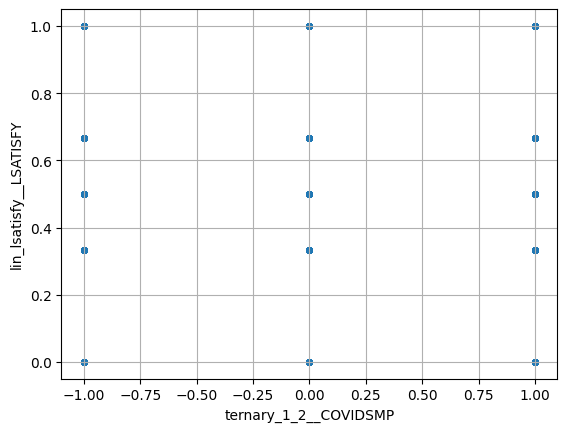

In [ ]:
brfss22_prepared_df.plot(kind='scatter',x='ternary_1_2__COVIDSMP',y='lin_lsatisfy__LSATISFY',alpha=0.002, grid=True)

In [32]:
brfss22_prepared_df.isnull().sum(axis=1).shape

(445132,)

In [35]:
# Count rows with at least one NaN
nan_rows_count = brfss22_df.isnull().any(axis=1).sum()
nan_cols_count = brfss22_df.isnull().any(axis=0).sum()

print(f"Number of rows with at least one NaN: {nan_rows_count}")
print(f"Number of columns with at least one NaN: {nan_cols_count}")


Number of rows with at least one NaN: 445132
Number of columns with at least one NaN: 279


In [36]:
# prompt: find the key names of the columns in brfss22_df that does not contain any nan values

# Find key names of columns without any NaN values
key_names_no_nan = brfss22_df.columns[brfss22_df.notna().all()].tolist()
key_names_no_nan


['_STATE',
 'FMONTH',
 'IDATE',
 'IMONTH',
 'IDAY',
 'IYEAR',
 'DISPCODE',
 'SEQNO',
 '_PSU',
 'SEXVAR',
 'QSTVER',
 'QSTLANG',
 '_STSTR',
 '_STRWT',
 '_RAWRAKE',
 '_WT2RAKE',
 '_IMPRACE',
 '_DUALUSE',
 '_LLCPWT2',
 '_LLCPWT',
 '_RFHLTH',
 '_PHYS14D',
 '_MENT14D',
 '_HLTHPLN',
 '_HCVU652',
 '_TOTINDA',
 '_EXTETH3',
 '_LTASTH1',
 '_CASTHM1',
 '_ASTHMS1',
 '_HISPANC',
 '_RACEPR1',
 '_SEX',
 '_AGEG5YR',
 '_AGE65YR',
 '_AGE80',
 '_AGE_G',
 '_RFBMI5',
 '_EDUCAG',
 '_INCOMG1',
 '_SMOKER3',
 '_RFSMOK3',
 '_CURECI2',
 'DRNKANY6',
 '_RFBING6',
 '_DRNKWK2',
 '_RFDRHV8']

# Load prepared data set

Maybe not a fruitful idea.scikit will not know anything about transform etc.

Better to run the transformation.

# Preparing for training

Now, COVIDSMP is a ternary feature, with -1 for 'no long-covid symptoms' and 0 for refused/not sure/missing. In order to treat it as a classification problem it is better if it is binary and if we skip the missing/refused/not sure, to have a more clear data (they do not add information).

It could have been done at an earlier stage, or it can be done at this point. Better to do it earlier?

One approach is to, for COVIDSMP, specifically, transform it like Yes=1, No=0, Refused/not sure/missing=-1. Then we will not make use of the data that has COVIDSMP=-1. Out of all COVIDPOS=1, we will drop the rows with COVIDSMP=-1. Afterwars, if the like and are successful we can try to predict what they would have answered.

The preprocessing is updated...

In [45]:
# make a mask to select all rows with COVIDPOS=1
# This is the start out set to be used for the analysis of effects from COVID
# It does not contain any missing/refused/not sure responses on that question.
# They are imuted as 0
mask_COVIDPOS_1 = brfss22_prepared_df['bin_13__COVIDPOS'] == 1
mask_COVIDPOS_0 = brfss22_prepared_df['bin_13__COVIDPOS'] == 0

# However, out of this selection there are some that refuses/are not sure/missing
# responses to the question whether they have long-covid symptoms. We only want to
# Include those that aswered yes/no.
# make a mask to select all rows with that are not COVIDSMP=-1
mask_COVIDSMP_valid = brfss22_prepared_df['ter_covidsmp__COVIDSMP'] != -1

# We may need a mask to select those that got long covid symptoms
mask_COVIDSMP_1 = brfss22_prepared_df['ter_covidsmp__COVIDSMP'] == 1

# The mask should have almost same number of True, COVIDPOS some more.
print(mask_COVIDPOS_1.sum())
print(mask_COVIDSMP_valid.sum())

# Apply the COVIDSMP mask to the DataFrame
brfss22_covid_df = brfss22_prepared_df[mask_COVIDSMP_valid].copy()

# Check values count
print(brfss22_covid_df['ter_covidsmp__COVIDSMP'].value_counts())
print(brfss22_covid_df['bin_13__COVIDPOS'].value_counts())
#

124313
121379
ter_covidsmp__COVIDSMP
0.0    94596
1.0    26783
Name: count, dtype: int64
bin_13__COVIDPOS
1.0    121379
Name: count, dtype: int64


In [ ]:
# Some potentiall interesting checks on the data of the different groups
# We can compare the statistics to see if something is changing in the features.
# The mean is the mean and ste std tells us something about the distribution,
# but it has to be interpreted from case to case (question, bin, ter, cat, lin)
brfss22_prepared_df.loc[mask_COVIDPOS_0].describe()

,bin_1__PVTRESD1,bin_1__PVTRESD3,bin_1___URBSTAT,bin_1___MICHD,bin_1___DRDXAR2,bin_1___HADCOLN,bin_1___HADSIGM,bin_1___DENVST3,bin_1___RFMAM22,bin_1___AIDTST4,...,cat_employ1__EMPLOY1_1.0,cat_employ1__EMPLOY1_2.0,cat_employ1__EMPLOY1_3.0,cat_employ1__EMPLOY1_4.0,cat_employ1__EMPLOY1_5.0,cat_employ1__EMPLOY1_6.0,cat_employ1__EMPLOY1_7.0,cat_employ1__EMPLOY1_8.0,cat_employ1__EMPLOY1_9.0,cat_covidprm__COVIDPRM
count,320819.000000,320819.000000,320819.000000,320819.000000,320819.000000,320819.000000,320819.000000,320819.000000,320819.000000,320819.000000,...,320819.000000,320819.000000,320819.000000,320819.00000,320819.000000,320819.000000,320819.000000,320819.000000,320819.00000,320819.0
mean,0.243695,0.753537,0.855221,0.093486,0.347626,0.477681,0.073802,0.650971,0.265464,0.257394,...,0.393175,0.087348,0.020429,0.01715,0.039970,0.022128,0.344471,0.062649,0.01268,0.0
std,0.429311,0.430952,0.351879,0.291112,0.476217,0.499502,0.261448,0.476664,0.441581,0.437199,...,0.488456,0.282345,0.141463,0.12983,0.195888,0.147099,0.475196,0.242331,0.11189,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0
25%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0
50%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0
75%,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.00000,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,0.0


# Plots

In [68]:
# Dataframe to be compared for their mean and std
df_list=[brfss22_prepared_df.loc[mask_COVIDPOS_0], brfss22_prepared_df.loc[mask_COVIDPOS_1], brfss22_prepared_df.loc[mask_COVIDSMP_1]]      # All that got long covid symptoms

In [94]:
# prompt: Similar as the plot above, but with the std for a df and feature indicated on its bar. The values of the mean and std should not be plotted, but a grid could be added. The bars could be more slender to fit more features in one plot. Try to fit 10 features and the 3 data frames in df_list.

import matplotlib.pyplot as plt
import numpy as np

def plot_feature_stats(df_list, features, colors):
    num_dfs = len(df_list)
    num_features = len(features)

    fig, ax = plt.subplots(figsize=(10, 5))  # Increased figure size
    x = np.arange(num_features)
    width = 0.2  # Narrowed bar width

    for i, df in enumerate(df_list):
        means = [df[feature].mean() for feature in features]
        stds = [df[feature].std() for feature in features]
        rects = ax.bar(x + i * width, means, width, label=f"DataFrame {i+1}", color=colors[i], yerr=stds, capsize=5) #Added yerr

    ax.set_ylabel("Mean")
    ax.set_title("Mean and Standard Deviation of Features")
    ax.set_xticks(x + width * (num_dfs -1 ) / 2)
    ax.set_xticklabels(features, rotation=45, ha="right")
    ax.legend()
    ax.grid(True, axis='y', linestyle='--') #Added grid
    plt.tight_layout()
    plt.show()

# Example usage (adjust features and colors as needed):
features_to_plot = ['bin_13__COVIDPOS', 'ter_covidsmp__COVIDSMP', 'ter_1_2__RENTHOM1', 'ter_12_3__PERSDOC3', 'ter_1_23__ACEPUNCH',
                    'bin_1__PVTRESD1', 'bin_12__USENOW3']
colors_for_plot = ['skyblue', 'lightcoral', 'lightgreen']
#plot_feature_stats(df_list[:3], brfss22_covid_df.columns[:15], colors_for_plot)


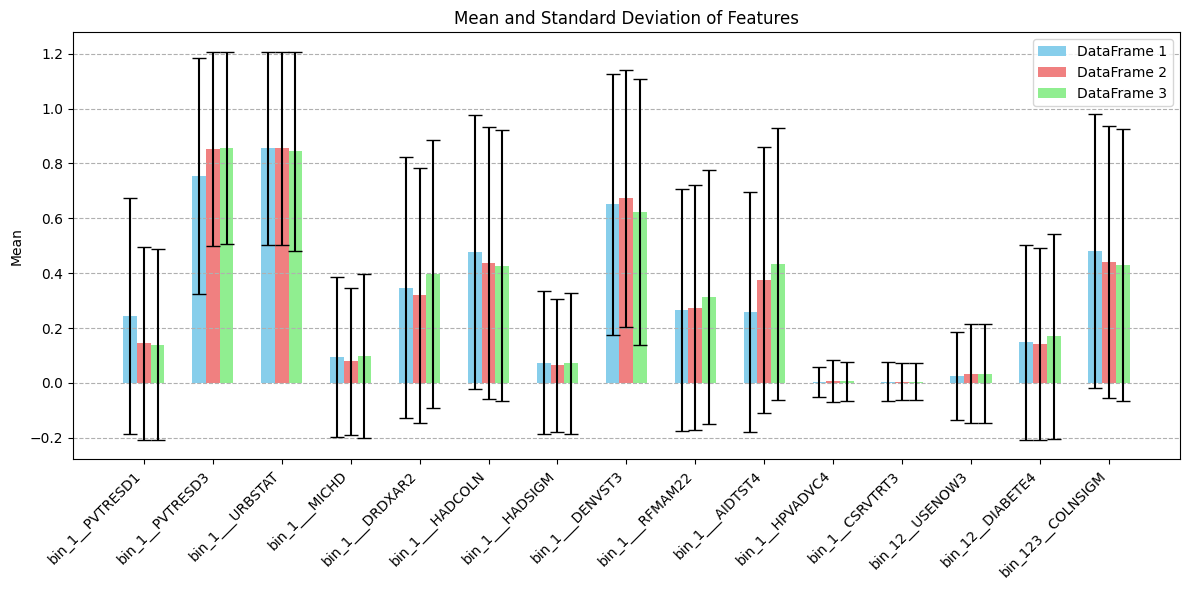

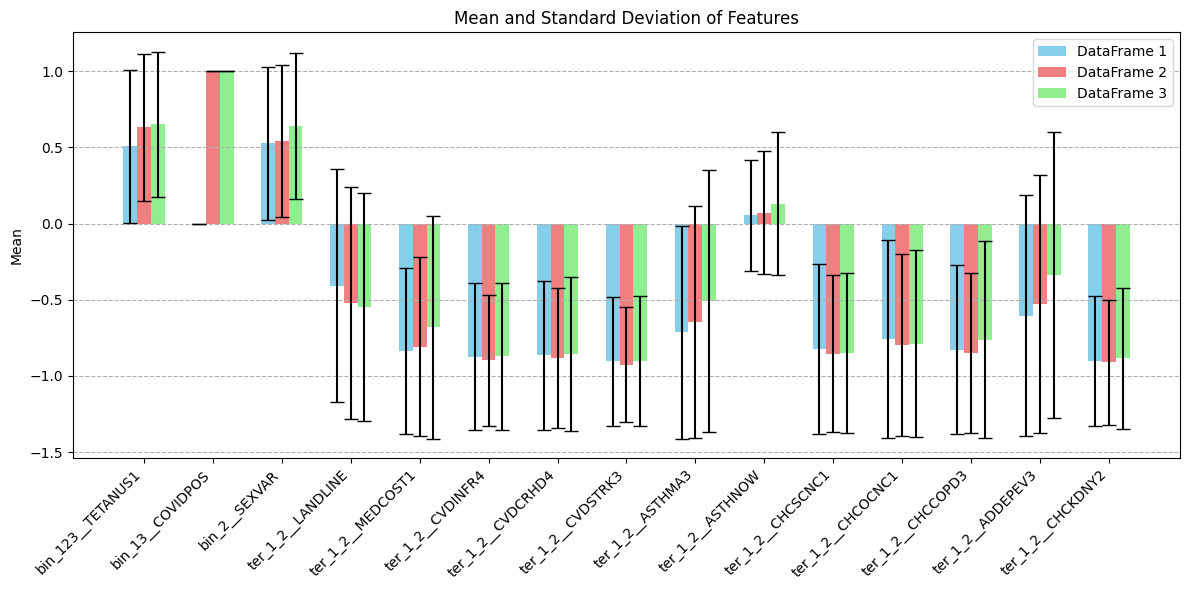

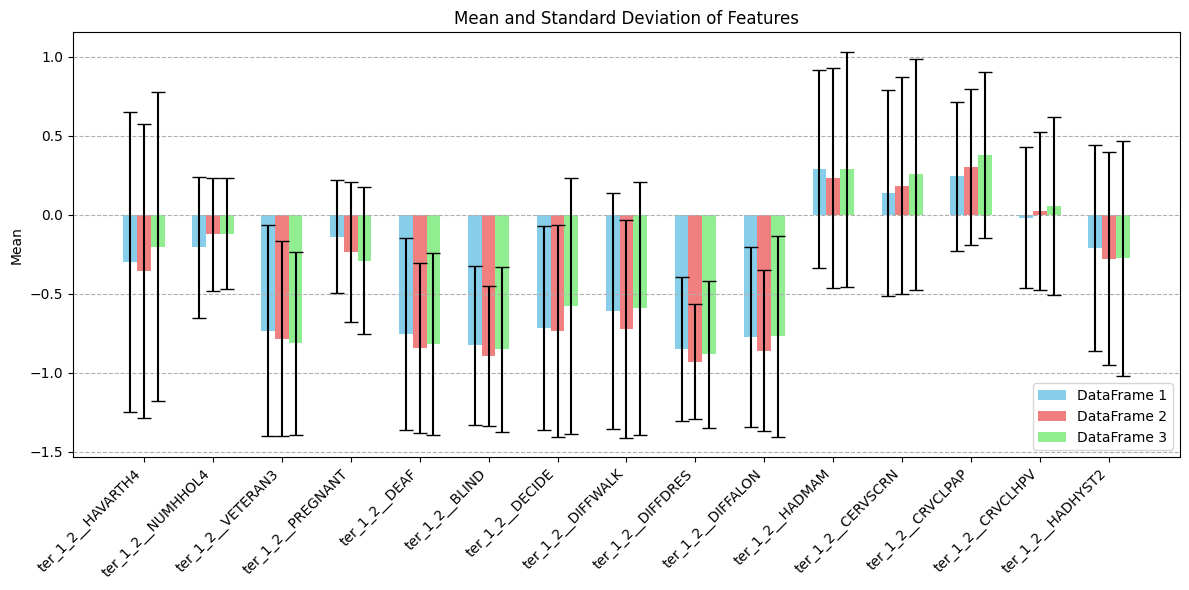

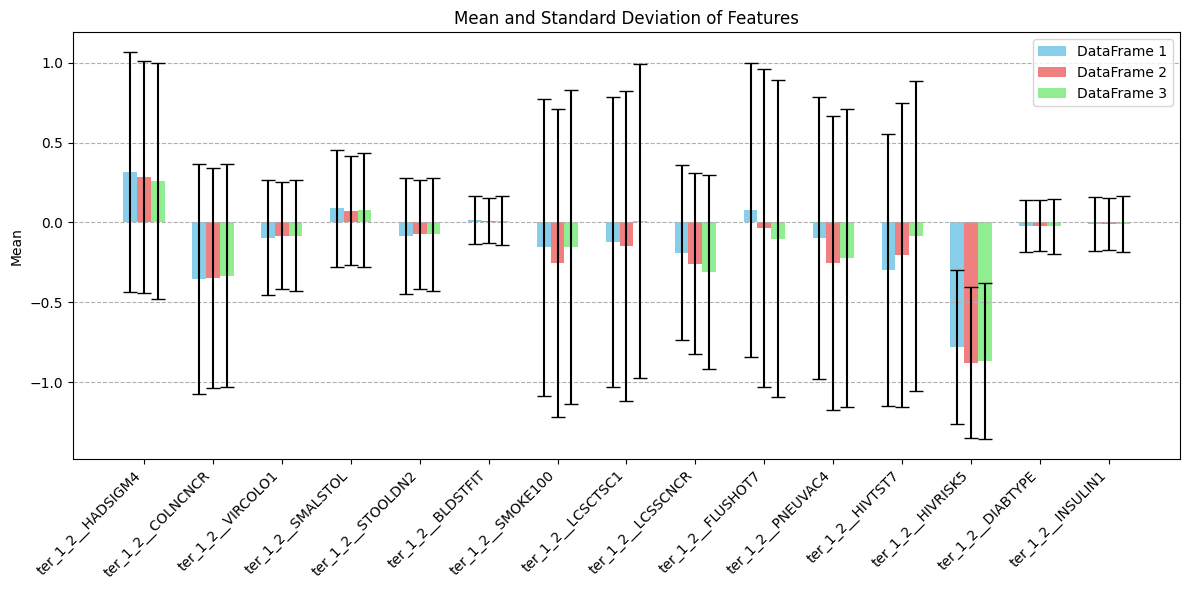

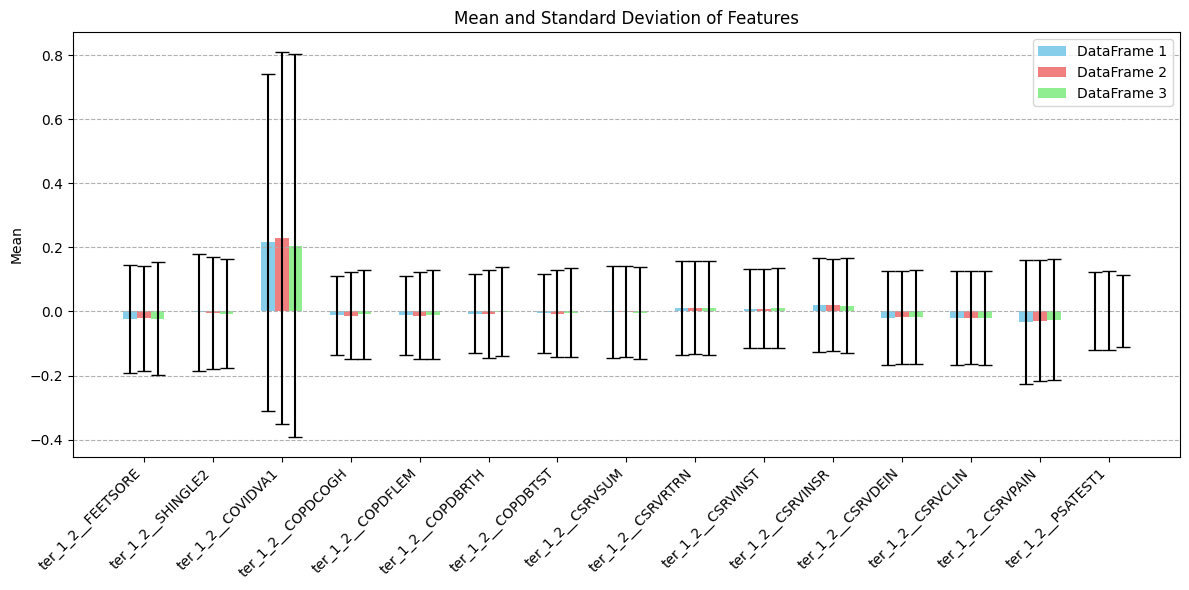

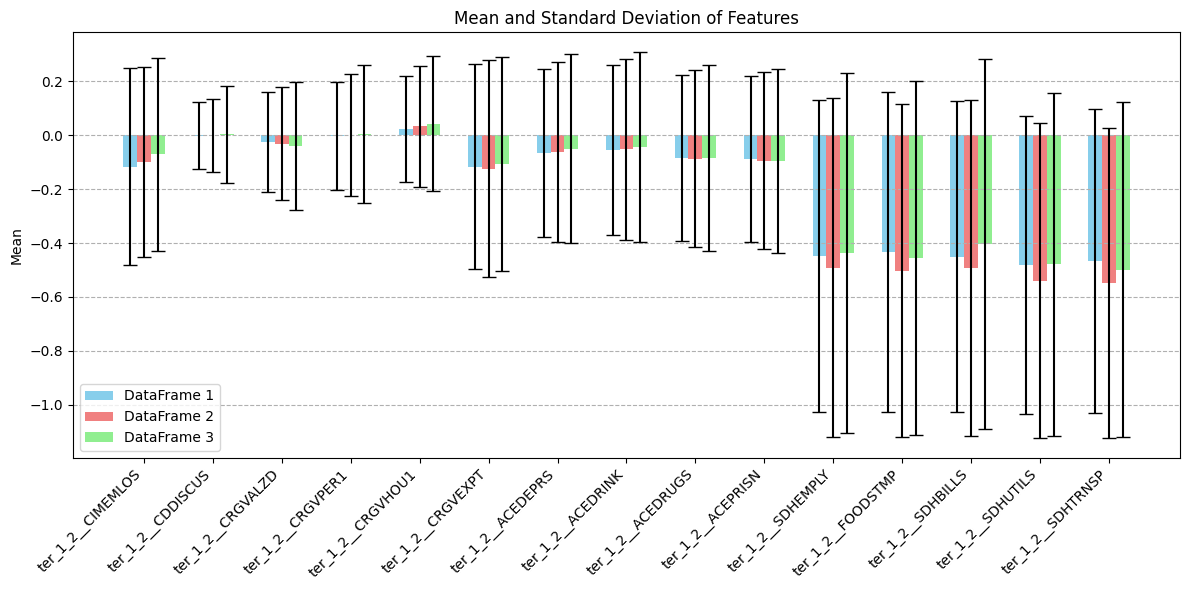

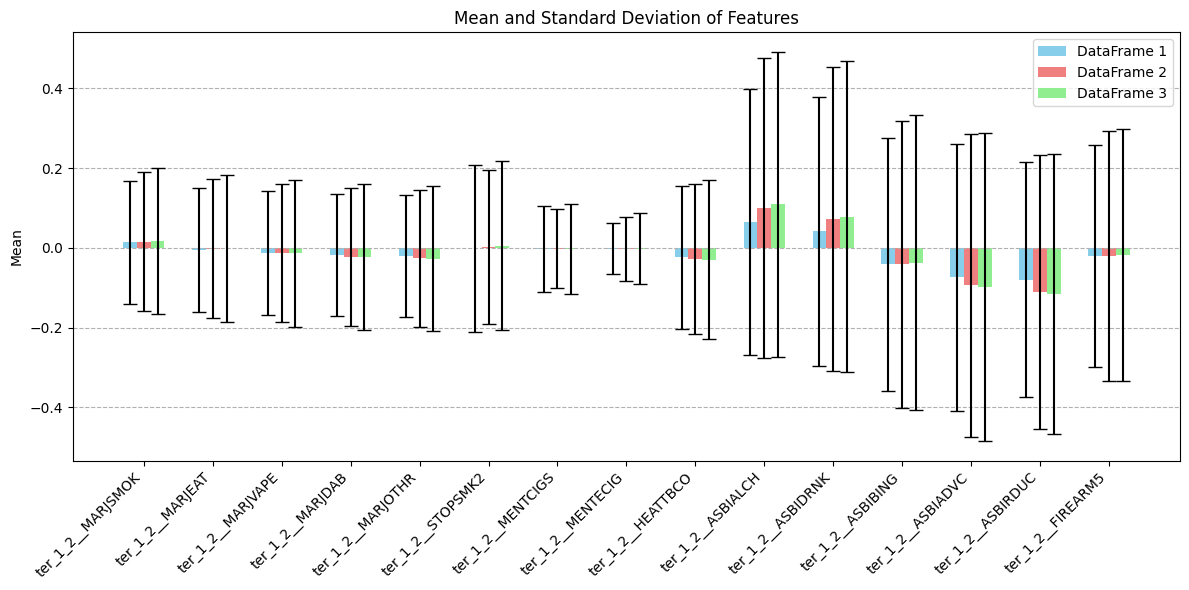

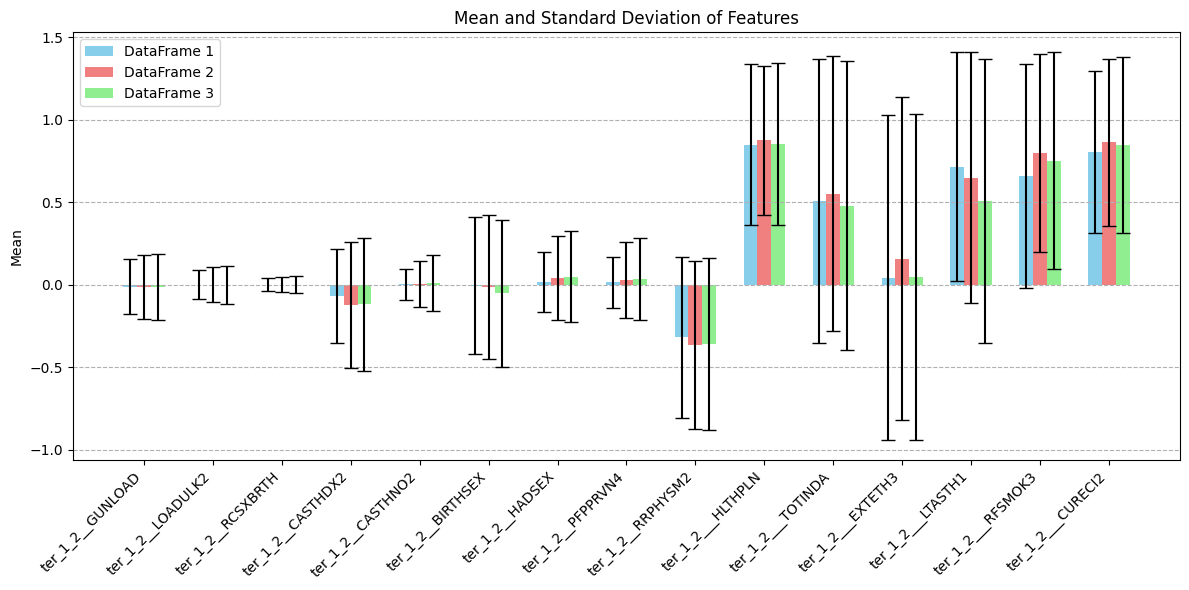

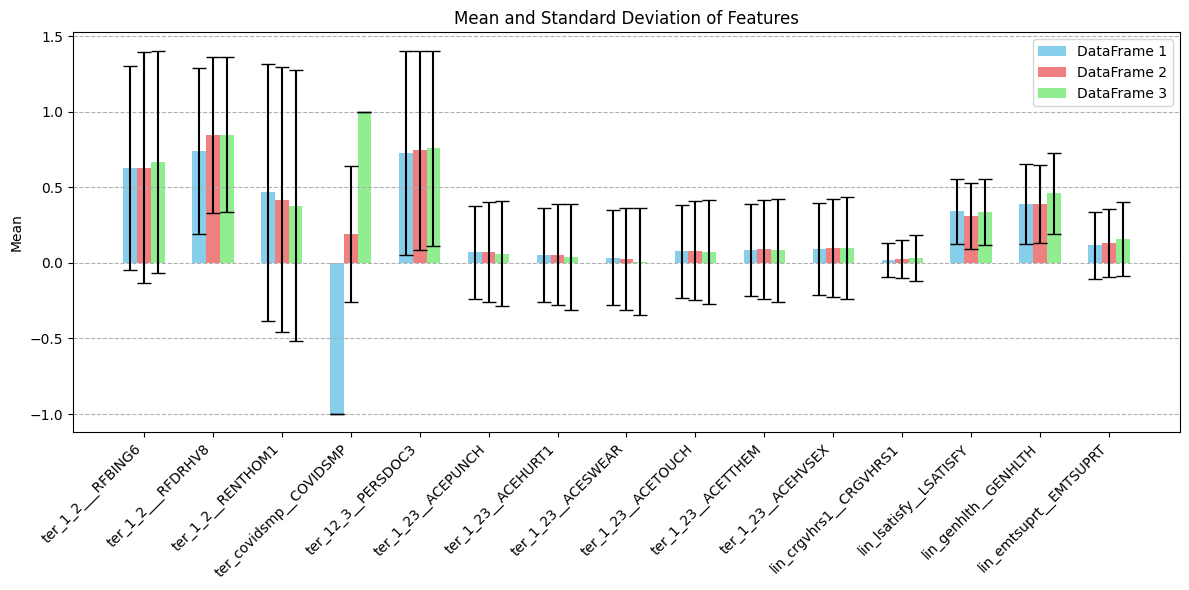

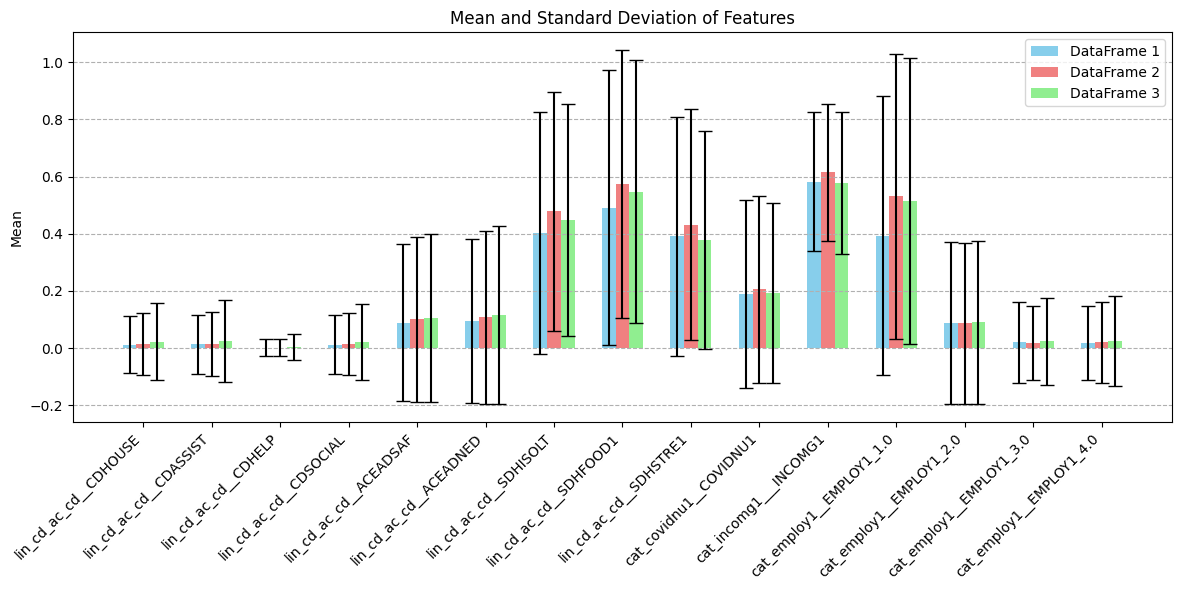

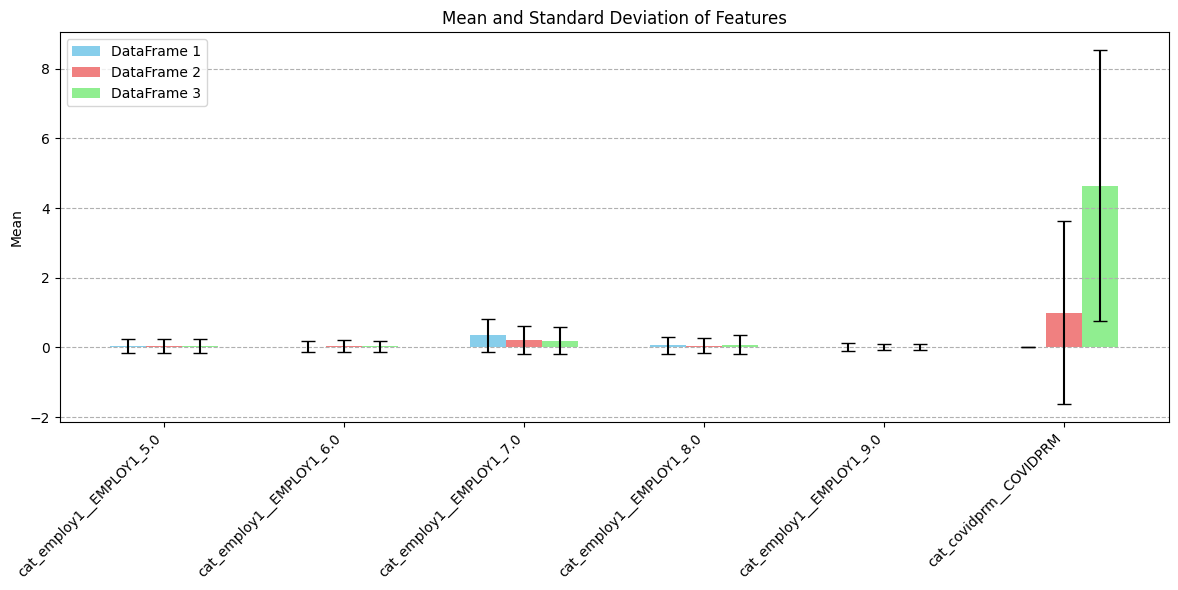

In [71]:
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[:15], colors_for_plot)
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[15:30], colors_for_plot)
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[30:45], colors_for_plot)
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[45:60], colors_for_plot)
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[60:75], colors_for_plot)
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[75:90], colors_for_plot)
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[90:105], colors_for_plot)
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[105:120], colors_for_plot)
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[120:135], colors_for_plot)
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[135:150], colors_for_plot)
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[150:156], colors_for_plot)

In [72]:
# It could be interesting to plot the distribution of the responses for
# the two groups yes and no, in a similar fashian as for the MNIST set,
# threating the values as pixels

# Create masks for 0 an 1 for COVIDSMP
# Making use of previously defined masks
# One could throw in also a mask for a specific primary symptom as well
mask_COVIDPRM_5=brfss22_prepared_df['cat_covidprm__COVIDPRM']==5

# For each mask one can calculate the mean of each feature.
# Then plot the mean as and 'image' by reshaping the result as 12 times 13
mean_COVIDPOS_0=brfss22_prepared_df.loc[mask_COVIDPOS_0].mean()
mean_COVIDSMP_valid=brfss22_prepared_df.loc[mask_COVIDSMP_valid].mean()
mean_COVIDPRM_5=brfss22_prepared_df.loc[mask_COVIDPRM_5].mean()

# Binary, ternary, linear differ, and ternary ans som other have the zero value
# the middle of the range. We can re-scale, so that all are same scale from zero to one
scaled_mean_COVIDPOS_0=(brfss22_prepared_df.loc[mask_COVIDPOS_0].mean()-brfss22_prepared_df.loc[mask_COVIDPOS_0].min())/(brfss22_prepared_df.loc[mask_COVIDPOS_0].max()-brfss22_prepared_df.loc[mask_COVIDPOS_0].min())
scaled_mean_COVIDSMP_valid=(brfss22_prepared_df.loc[mask_COVIDSMP_valid].mean()-brfss22_prepared_df.loc[mask_COVIDSMP_valid].min())/(brfss22_prepared_df.loc[mask_COVIDSMP_valid].max()-brfss22_prepared_df.loc[mask_COVIDSMP_valid].min())
scaled_mean_COVIDPRM_5=(brfss22_prepared_df.loc[mask_COVIDPRM_5].mean()-brfss22_prepared_df.loc[mask_COVIDPRM_5].min())/(brfss22_prepared_df.loc[mask_COVIDPRM_5].max()-brfss22_prepared_df.loc[mask_COVIDPRM_5].min())


In [73]:
mean_COVIDSMP_0.shape

NameError: name 'mean_COVIDSMP_0' is not defined

In [52]:
brfss22_covid_df.shape

(121379, 156)

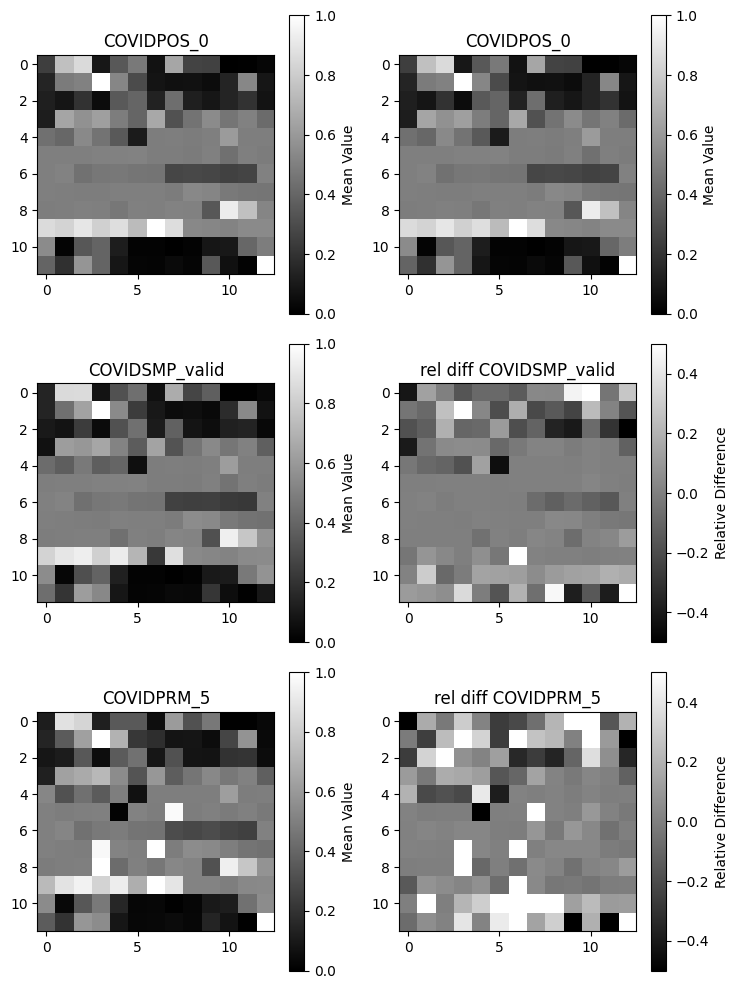

<Figure size 640x480 with 0 Axes>

In [86]:
import matplotlib.pyplot as plt

# Assuming mean_COVIDPOS_0, mean_COVIDSMP_valid, and mean_COVIDPRM_5 are defined as in your code

# Reshape the means into 12x13 images
image_shape = (12, 13)

image_COVIDPOS_0 = scaled_mean_COVIDPOS_0.values.reshape(image_shape)
image_COVIDSMP_valid = scaled_mean_COVIDSMP_valid.values.reshape(image_shape)
image_COVIDPRM_5 = scaled_mean_COVIDPRM_5.values.reshape(image_shape)

diff_1=(-image_COVIDPOS_0+image_COVIDSMP_valid)/image_COVIDPOS_0
diff_2=(-image_COVIDPOS_0+image_COVIDPRM_5)/image_COVIDPOS_0

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(7.5, 10))  # Adjust figsize as needed

# Plot each image
im1 = axes[0,0].imshow(image_COVIDPOS_0, cmap='gray', vmin=0, vmax=1) # Set scale
axes[0,0].set_title("COVIDPOS_0")
im2 = axes[1,0].imshow(image_COVIDSMP_valid, cmap='gray', vmin=0, vmax=1) # Set scale
axes[1,0].set_title("COVIDSMP_valid")
im3 = axes[2,0].imshow(image_COVIDPRM_5, cmap='gray', vmin=0, vmax=1) # Set scale
axes[2,0].set_title("COVIDPRM_5")
im4 = axes[0,1].imshow(image_COVIDPOS_0, cmap='gray', vmin=0, vmax=1) # Set scale
axes[0,1].set_title("COVIDPOS_0")
im5 = axes[1,1].imshow(diff_1, cmap='gray', vmin=-0.5, vmax=0.5) # Set scale
axes[1,1].set_title("rel diff COVIDSMP_valid")
im6 = axes[2,1].imshow(diff_2, cmap='gray', vmin=-0.5, vmax=0.5) # Set scale
axes[2,1].set_title("rel diff COVIDPRM_5")

# Add colorbars with appropriate labels
fig.colorbar(im1, ax=axes[0,0], label='Mean Value')
fig.colorbar(im2, ax=axes[1,0], label='Mean Value')
fig.colorbar(im3, ax=axes[2,0], label='Mean Value')
fig.colorbar(im4, ax=axes[0,1], label='Mean Value')
fig.colorbar(im5, ax=axes[1,1], label='Relative Difference')
fig.colorbar(im6, ax=axes[2,1], label='Relative Difference')

plt.tight_layout()
plt.show()

#plt.savefig('/content/drive/MyDrive/pics/image_plots_13_12.png')


# Report Images

In [87]:
# It could be interesting to plot the distribution of the responses for
# the two groups yes and no, in a similar fashian as for the MNIST set,
# threating the values as pixels

# Create masks for 0 an 1 for COVIDSMP
# Making use of previously defined masks
# One could throw in also a mask for a specific primary symptom as well
mask_COVIDPRM_5=brfss22_prepared_df['cat_covidprm__COVIDPRM']==5

# For each mask one can calculate the mean of each feature.
# Then plot the mean as and 'image' by reshaping the result as 12 times 13
mean_COVIDPOS_0=brfss22_prepared_df.loc[mask_COVIDPOS_0].mean()
mean_COVIDSMP_valid=brfss22_prepared_df.loc[mask_COVIDSMP_valid].mean()
mean_COVIDSMP_1=brfss22_prepared_df.loc[mask_COVIDSMP_1].mean()
mean_COVIDPRM_5=brfss22_prepared_df.loc[mask_COVIDPRM_5].mean()

# Binary, ternary, linear differ, and ternary ans som other have the zero value
# the middle of the range. We can re-scale, so that all are same scale from zero to one
scaled_mean_COVIDPOS_0=(brfss22_prepared_df.loc[mask_COVIDPOS_0].mean()-brfss22_prepared_df.loc[mask_COVIDPOS_0].min())/(brfss22_prepared_df.loc[mask_COVIDPOS_0].max()-brfss22_prepared_df.loc[mask_COVIDPOS_0].min())
scaled_mean_COVIDSMP_valid=(brfss22_prepared_df.loc[mask_COVIDSMP_valid].mean()-brfss22_prepared_df.loc[mask_COVIDSMP_valid].min())/(brfss22_prepared_df.loc[mask_COVIDSMP_valid].max()-brfss22_prepared_df.loc[mask_COVIDSMP_valid].min())
scaled_mean_COVIDSMP_1=(brfss22_prepared_df.loc[mask_COVIDSMP_1].mean()-brfss22_prepared_df.loc[mask_COVIDSMP_1].min())/(brfss22_prepared_df.loc[mask_COVIDSMP_1].max()-brfss22_prepared_df.loc[mask_COVIDSMP_1].min())
scaled_mean_COVIDPRM_5=(brfss22_prepared_df.loc[mask_COVIDPRM_5].mean()-brfss22_prepared_df.loc[mask_COVIDPRM_5].min())/(brfss22_prepared_df.loc[mask_COVIDPRM_5].max()-brfss22_prepared_df.loc[mask_COVIDPRM_5].min())


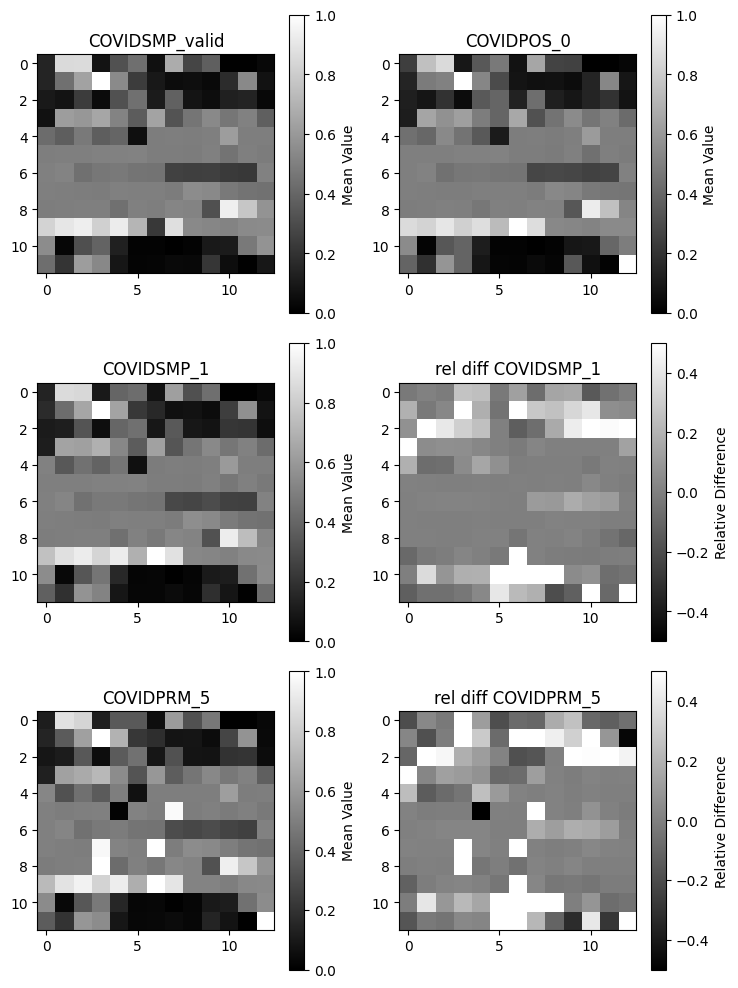

In [89]:
#Report images

# Reshape the means into 12x13 images
image_shape = (12, 13)

image_COVIDPOS_0 = scaled_mean_COVIDPOS_0.values.reshape(image_shape)
image_COVIDSMP_valid = scaled_mean_COVIDSMP_valid.values.reshape(image_shape)
image_COVIDSMP_1 = scaled_mean_COVIDSMP_1.values.reshape(image_shape)
image_COVIDPRM_5 = scaled_mean_COVIDPRM_5.values.reshape(image_shape)

diff_1=(-image_COVIDSMP_valid+image_COVIDSMP_1)/image_COVIDSMP_valid
diff_2=(-image_COVIDSMP_valid+image_COVIDPRM_5)/image_COVIDSMP_valid

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(7.5, 10))  # Adjust figsize as needed

# Plot each image
im1 = axes[0,0].imshow(image_COVIDSMP_valid, cmap='gray', vmin=0, vmax=1) # Set scale
axes[0,0].set_title("COVIDSMP_valid")
im2 = axes[1,0].imshow(image_COVIDSMP_1, cmap='gray', vmin=0, vmax=1) # Set scale
axes[1,0].set_title("COVIDSMP_1")
im3 = axes[2,0].imshow(image_COVIDPRM_5, cmap='gray', vmin=0, vmax=1) # Set scale
axes[2,0].set_title("COVIDPRM_5")
im4 = axes[0,1].imshow(image_COVIDPOS_0, cmap='gray', vmin=0, vmax=1) # Set scale
axes[0,1].set_title("COVIDPOS_0")
im5 = axes[1,1].imshow(diff_1, cmap='gray', vmin=-0.5, vmax=0.5) # Set scale
axes[1,1].set_title("rel diff COVIDSMP_1")
im6 = axes[2,1].imshow(diff_2, cmap='gray', vmin=-0.5, vmax=0.5) # Set scale
axes[2,1].set_title("rel diff COVIDPRM_5")

# Add colorbars with appropriate labels
fig.colorbar(im1, ax=axes[0,0], label='Mean Value')
fig.colorbar(im2, ax=axes[1,0], label='Mean Value')
fig.colorbar(im3, ax=axes[2,0], label='Mean Value')
fig.colorbar(im4, ax=axes[0,1], label='Mean Value')
fig.colorbar(im5, ax=axes[1,1], label='Relative Difference')
fig.colorbar(im6, ax=axes[2,1], label='Relative Difference')

plt.tight_layout()
plt.show()


In [92]:
# Dataframe to be compared for their mean and std
df_list=[brfss22_prepared_df.loc[mask_COVIDSMP_valid], brfss22_prepared_df.loc[mask_COVIDSMP_1], brfss22_prepared_df.loc[mask_COVIDPRM_5]]      # All that got long covid symptoms

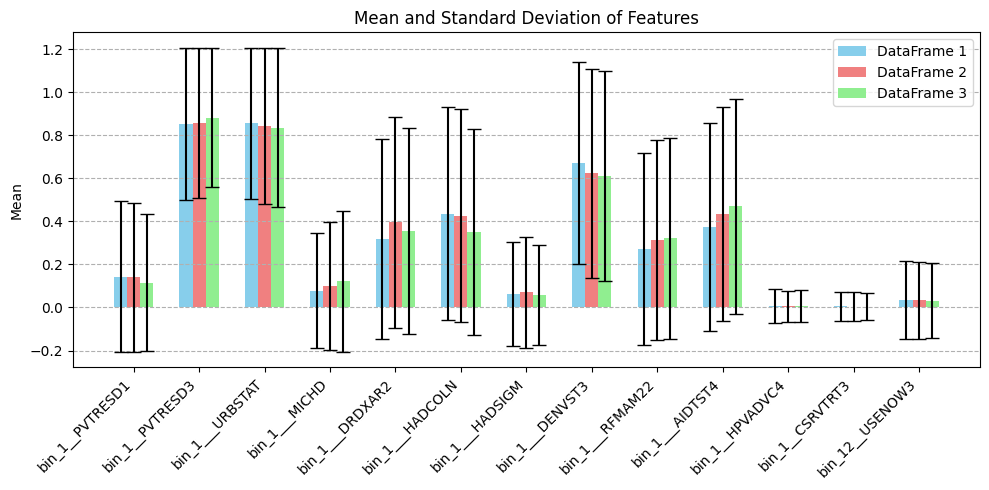

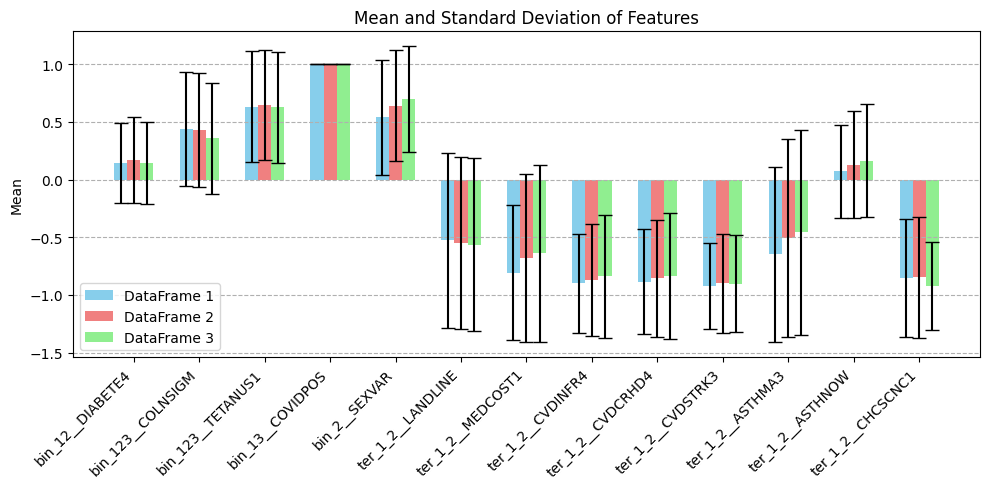

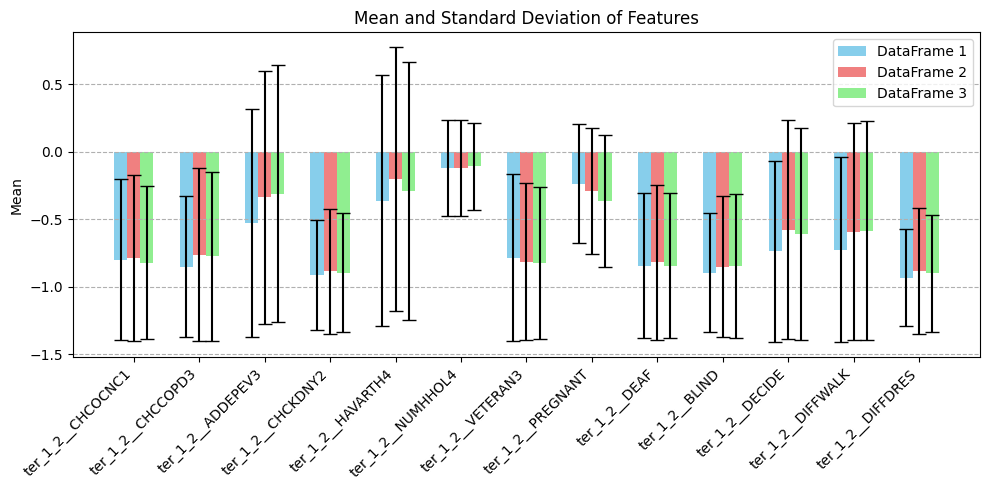

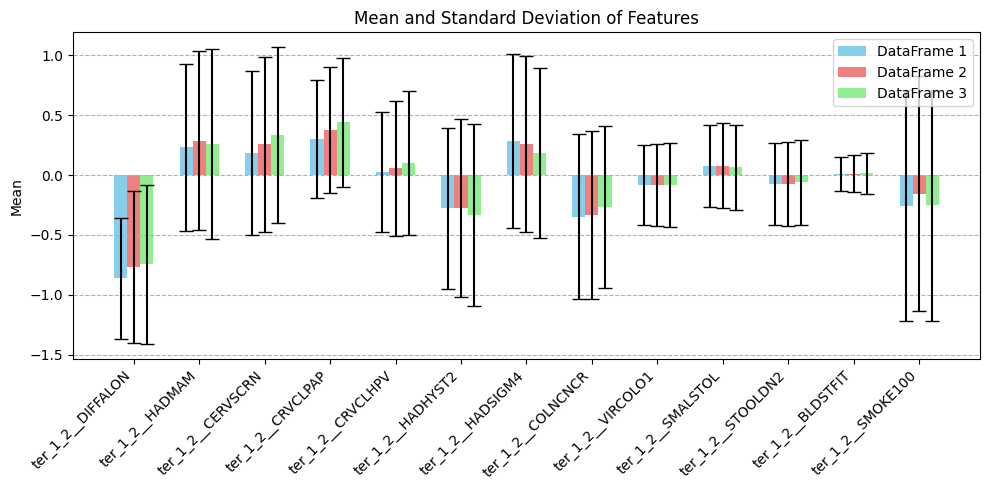

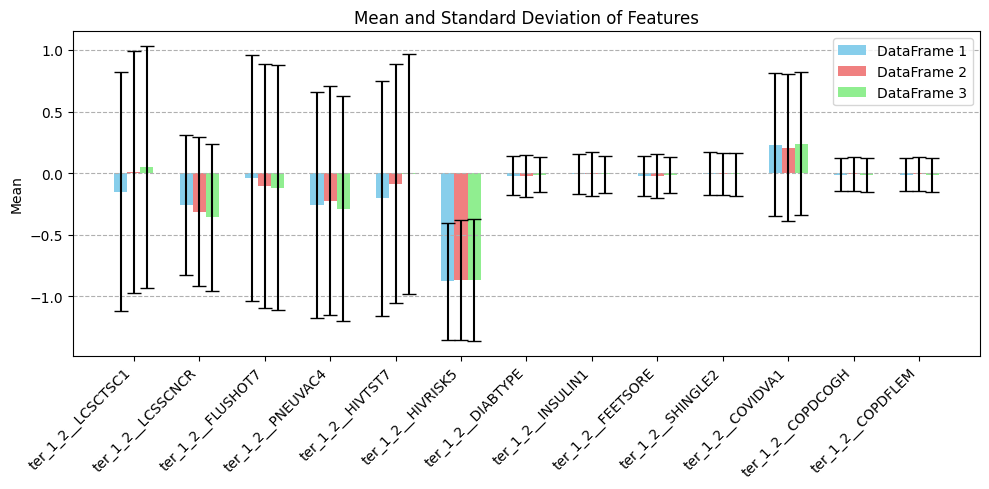

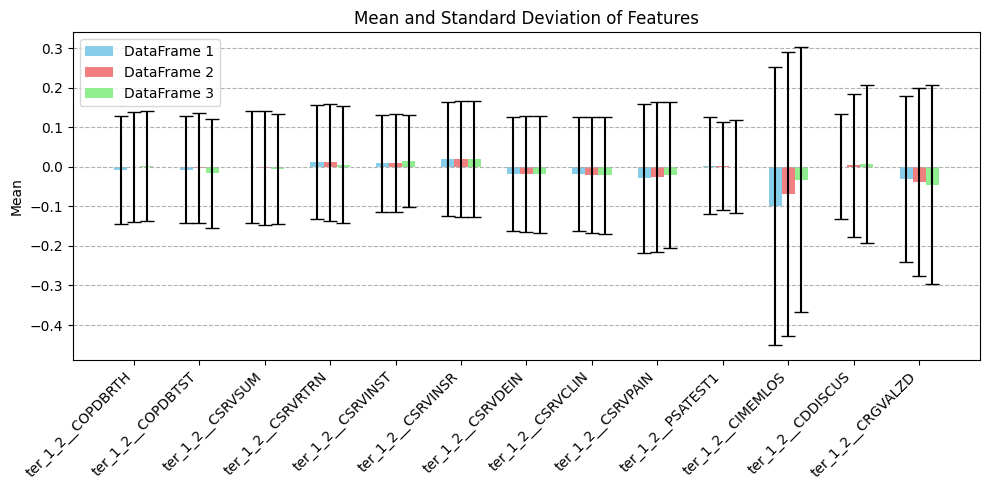

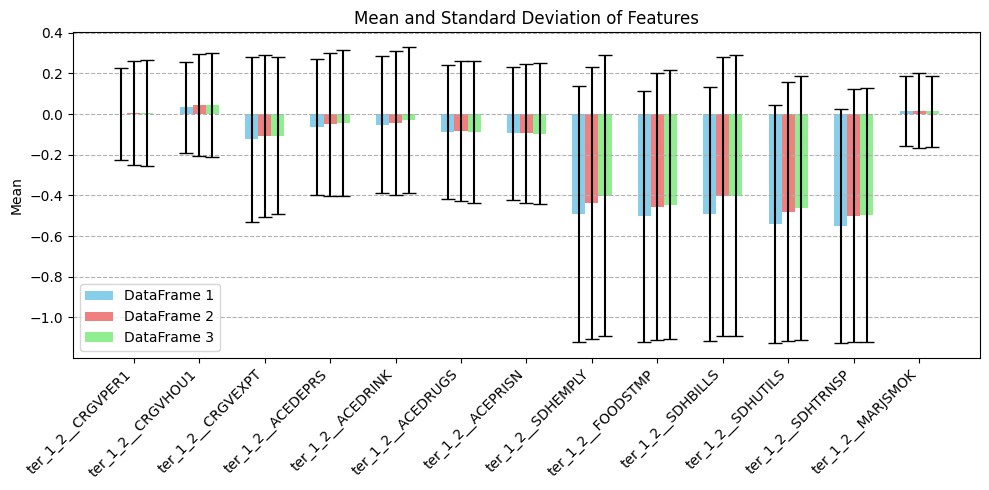

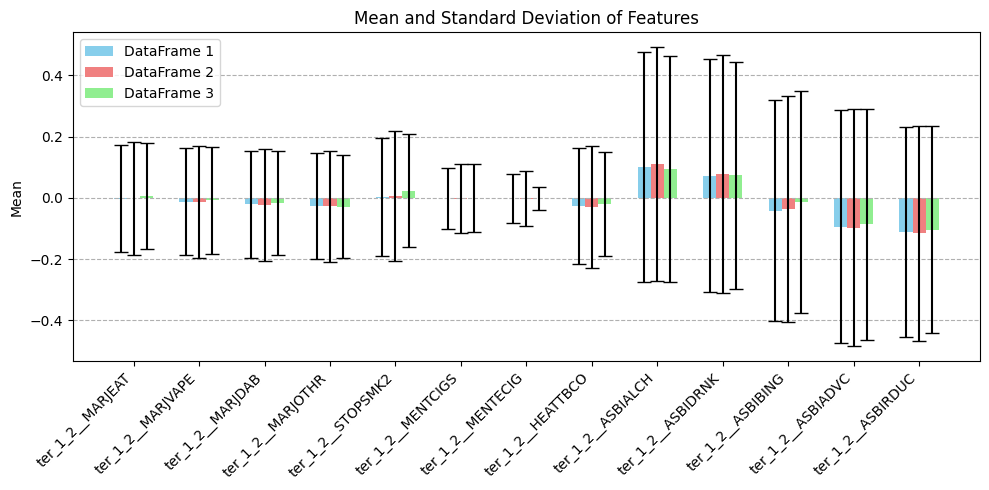

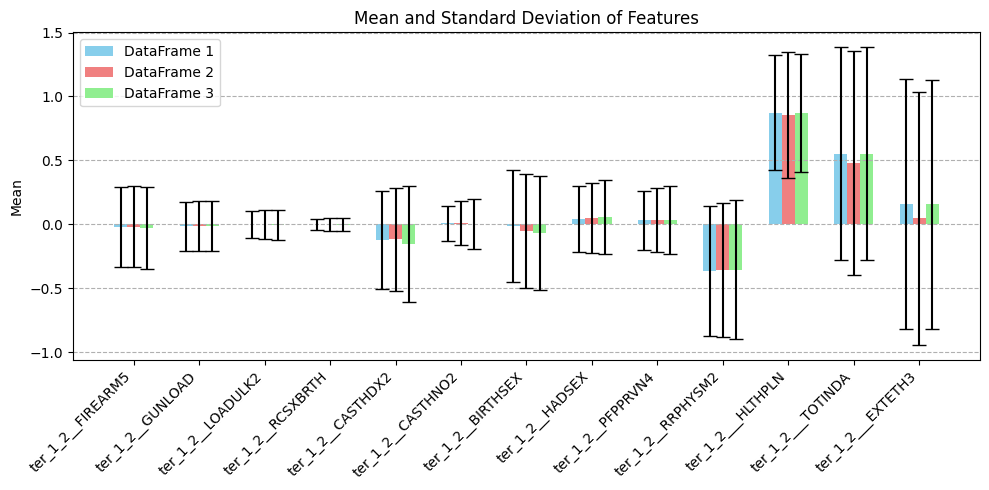

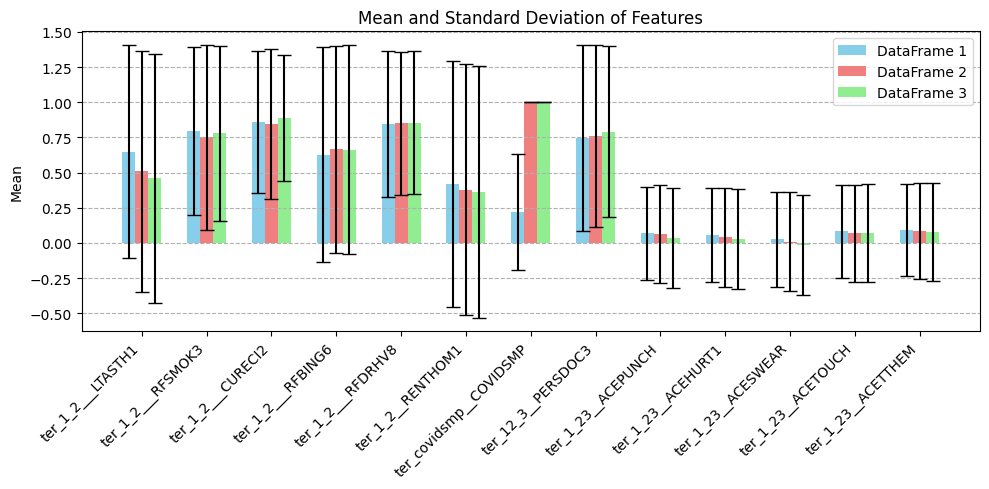

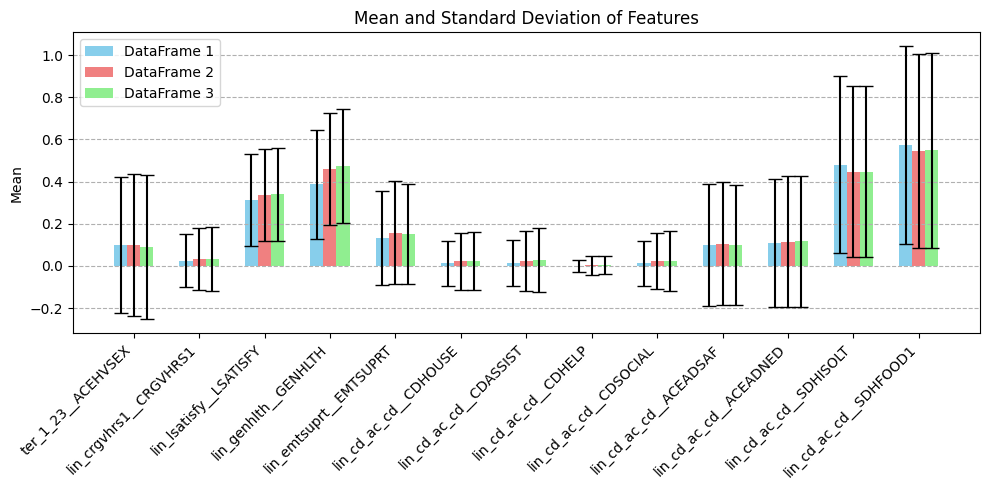

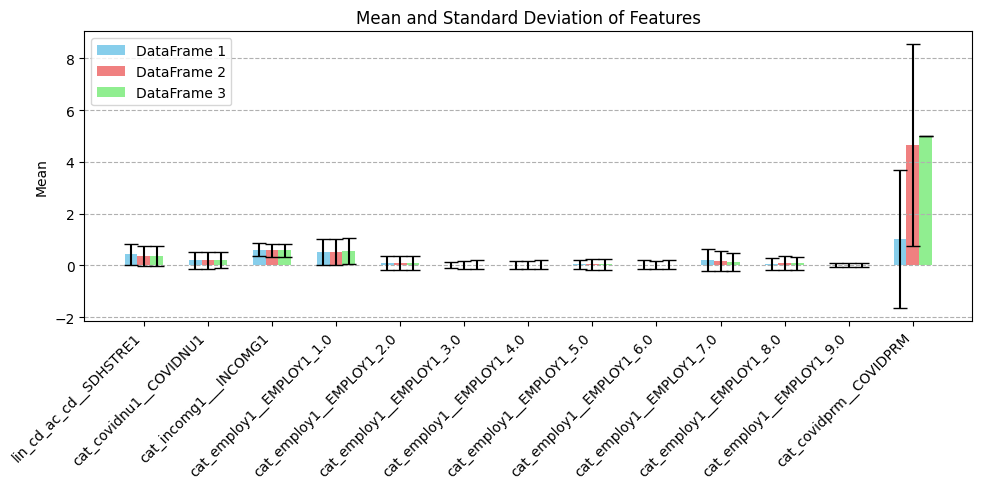

In [96]:
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[:13], colors_for_plot)
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[13:26], colors_for_plot)
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[26:39], colors_for_plot)
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[39:52], colors_for_plot)
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[52:65], colors_for_plot)
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[65:78], colors_for_plot)
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[78:91], colors_for_plot)
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[91:104], colors_for_plot)
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[104:117], colors_for_plot)
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[117:130], colors_for_plot)
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[130:143], colors_for_plot)
plot_feature_stats(df_list[:3], brfss22_covid_df.columns[143:156], colors_for_plot)


# Training

In [46]:
# Now, divide the dataset into training and test set with scikit
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(brfss22_covid_df, test_size=0.2, random_state=42)

# Divide the data set into data and label
# For the first step we do not want to include any long-covid related
# information, so we must drop some features that should not be in the training
# data.
features_to_drop=['bin_13__COVIDPOS', 'ter_covidsmp__COVIDSMP','cat_covidprm__COVIDPRM']
#train_set=train_set.drop(features_to_drop,axis=1)
#test_set=test_set.drop(features_to_drop,axis=1)

X_train=train_set.drop(features_to_drop,axis=1)
y_train=train_set['ter_covidsmp__COVIDSMP'].copy()
X_test=test_set.drop(features_to_drop,axis=1)
y_test=test_set['ter_covidsmp__COVIDSMP'].copy()


# Decision Tree

In [98]:
# prompt: A decision tree analysis on X_train, using cross-correlation with cv=3

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

# Assuming X_train and y_train are defined as in the provided code

tree_clf = DecisionTreeClassifier(random_state=42)
scores_tree = cross_val_score(tree_clf, X_train, y_train, cv=3, scoring="accuracy")

print("Cross-validation scores:", scores_tree)
print("Mean accuracy:", scores_tree.mean())


Cross-validation scores: [0.66686233 0.66905586 0.66648129]
Mean accuracy: 0.6674664944934573


In [99]:
# prompt: Compare with the same analysis using the dummy classifier

from sklearn.dummy import DummyClassifier

# Create a dummy classifier
dummy_clf = DummyClassifier(strategy="most_frequent")  # Use the most frequent class as prediction

# Train the dummy classifier
dummy_clf.fit(X_train, y_train)

# Evaluate the dummy classifier using cross-validation
dummy_scores = cross_val_score(dummy_clf, X_train, y_train, cv=3, scoring="accuracy")

print("Dummy classifier cross-validation scores:", dummy_scores)
print("Dummy classifier mean accuracy:", dummy_scores.mean())


Dummy classifier cross-validation scores: [0.77931908 0.77931908 0.77931226]
Dummy classifier mean accuracy: 0.7793168078787948


In [100]:
# prompt: run a cross_val_predict on the tree_clf, print the confusion matrix

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# Assuming X_train, y_train, and tree_clf are defined as in the previous code

y_train_tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=3)

conf_mx = confusion_matrix(y_train, y_train_tree_pred)
conf_mx


array([[58424, 17250],
       [15040,  6389]])

In [101]:
# prompt: calculate precision and recall

from sklearn.metrics import precision_score, recall_score

# Assuming y_train and y_train_pred are defined from previous code

# Calculate precision
precision_tree = precision_score(y_train, y_train_tree_pred)
print(f"Precision: {precision_tree}")

# Calculate recall
recall_tree = recall_score(y_train, y_train_tree_pred)
print(f"Recall: {recall_tree}")


Precision: 0.27027370024112696
Recall: 0.2981473703859256


In [102]:
# Re-calculate scores with decision_function
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming y_train and y_train_pred are defined from previous
proba_scores_tree = cross_val_predict(tree_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]

# Calculate the accumulated roc score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, proba_scores_tree)

np.float64(0.5350458664638056)

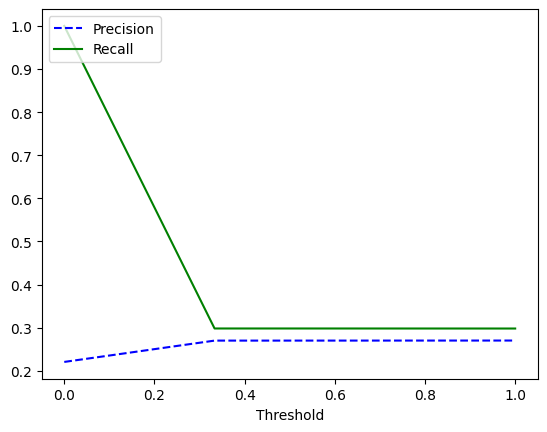

In [103]:
# Calculate precision and recall to generate the precision_recall_curve
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, proba_scores_tree)

# Plot the precision and recall curves
import matplotlib.pyplot as plt

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="upper left")

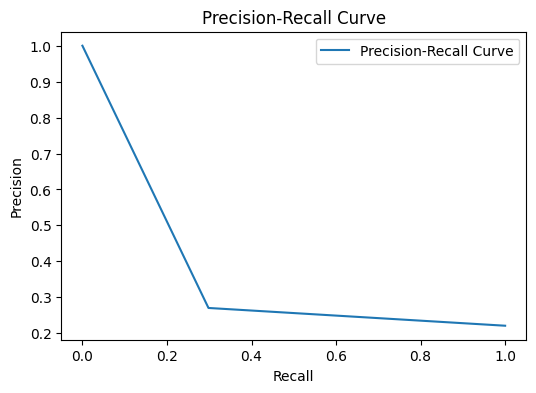

In [104]:
# Plot precision against recall
plt.figure(figsize=(6, 4))
plt.plot(recalls, precisions, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

# Logistic regression

In [105]:
# A logistic regression analysis using X_train and cv=3
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Assuming X_train and y_train are defined as in the provided code

log_reg = LogisticRegression(random_state=42)
log_scores= cross_val_score(log_reg, X_train, y_train, cv=3, scoring="accuracy")

print("Cross-validation scores:", log_scores)
print("Mean accuracy:", log_scores.mean())

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Cross-validation scores: [0.78179066 0.78064755 0.78218556]
Mean accuracy: 0.7815412566481234


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [106]:
# Run a cross_val_predict on the log_reg, print the confusion matrix
y_train_log_pred=cross_val_predict(log_reg, X_train, y_train, cv=3)

conf_mx = confusion_matrix(y_train, y_train_log_pred)
conf_mx

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

array([[74188,  1486],
       [19727,  1702]])

In [107]:
# Calculate precision
precision_log = precision_score(y_train, y_train_log_pred)
print(f"Precision: {precision_log}")

# Calculate recall
recall_log = recall_score(y_train, y_train_log_pred)
print(f"Recall: {recall_log}")

Precision: 0.5338770388958595
Recall: 0.07942507816510336


In [108]:
# Assuming y_train and y_train_pred are defined from previous
proba_scores_log = cross_val_predict(log_reg, X_train, y_train, cv=3, method="predict_log_proba")[:, 1]

# Calculate the accumulated roc score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, proba_scores_log)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

np.float64(0.6727648276451884)

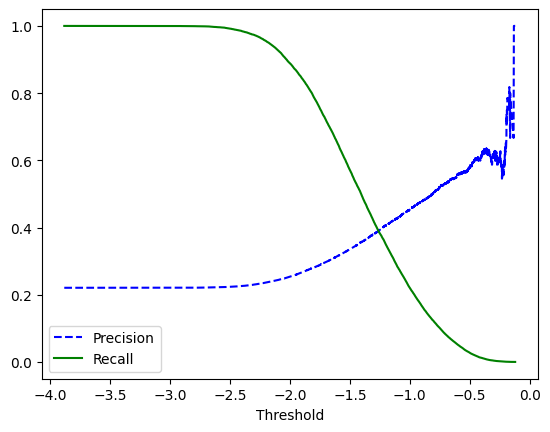

In [109]:
# Calculate precision and recall to generate the precision_recall_curve
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, proba_scores_log)

# Plot the precision and recall curves
import matplotlib.pyplot as plt

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")

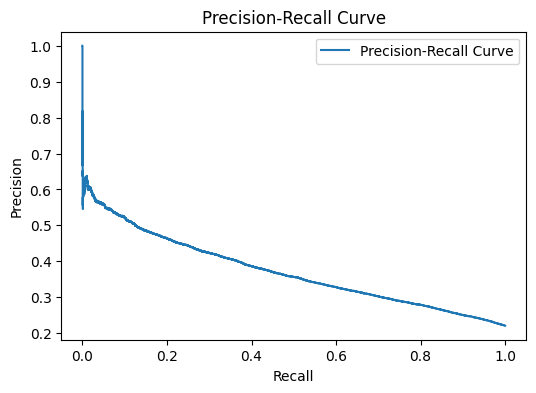

In [110]:
# Plot precisions against recalls
plt.figure(figsize=(6, 4))
plt.plot(recalls, precisions, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

In [90]:
# Calculate the accumulated roc score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, proba_scores_log)

np.float64(0.9836847780315847)

# Stochastic Gradient Descent

In [111]:
# prompt: A Stochastic gradient descent analysis on X_train, using cross-correlation with cv=3

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score

# Assuming X_train and y_train are defined as in the provided code

sgd_clf = SGDClassifier(random_state=42)
scores_sgd = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

print("Cross-validation scores:", scores_sgd)
print("Mean accuracy:", scores_sgd.mean())


Cross-validation scores: [0.77947355 0.77959713 0.77962122]
Mean accuracy: 0.7795639687471078


In [112]:
# Assuming X_train, y_train, and tree_clf are defined as in the previous code

y_train_sgd_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

conf_mx = confusion_matrix(y_train, y_train_sgd_pred)
conf_mx


array([[75640,    34],
       [21371,    58]])

In [113]:
# Calculate precision
precision_sgd = precision_score(y_train, y_train_sgd_pred)
print(f"Precision: {precision_sgd}")

# Calculate recall
recall_sgd = recall_score(y_train, y_train_sgd_pred)
print(f"Recall: {recall_sgd}")

Precision: 0.6304347826086957
Recall: 0.0027066125344159782


In [114]:
# Assuming y_train and y_train_pred are defined from previous
decision_scores_sgd = cross_val_predict(sgd_clf, X_train, y_train, cv=3, method="decision_function")

# Calculate the accumulated roc score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, decision_scores_sgd)

np.float64(0.6010776368063656)

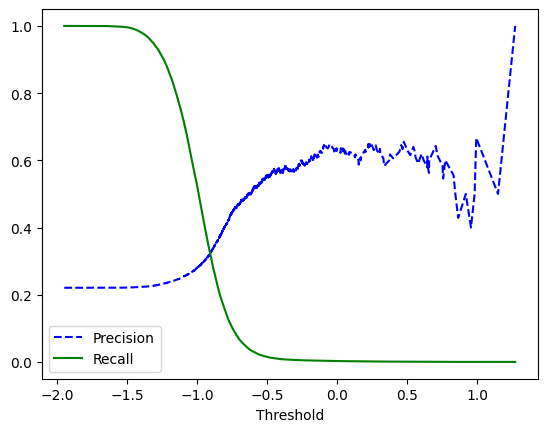

In [115]:
# Calculate precision and recall to generate the precision_recall_curve
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, decision_scores_sgd)

# Plot the precision and recall curves
import matplotlib.pyplot as plt

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")

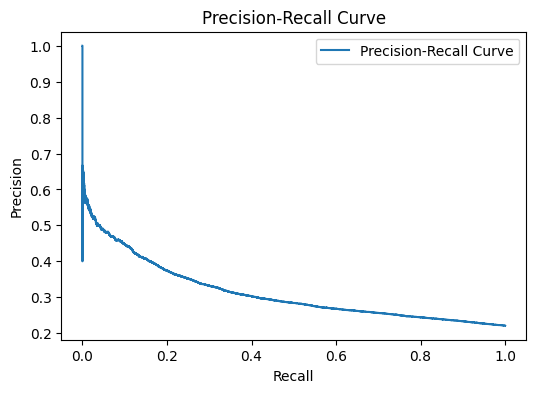

In [116]:
# Plot precisions against recalls
plt.figure(figsize=(6, 4))
plt.plot(recalls, precisions, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

In [117]:
# Calculate the accumulated roc score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, decision_scores_sgd)

np.float64(0.6010776368063656)

# Random Forest Classifier

In [118]:
# prompt: A Random Forest Classifier analysis on X_train, using cross-correlation with cv=3

from sklearn.ensemble import RandomForestClassifier

# Assuming X_train and y_train are defined as in the provided code

forest_clf = RandomForestClassifier(random_state=42)
scores_forest = cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

print("Cross-validation scores:", scores_forest)
print("Mean accuracy:", scores_forest.mean())


Cross-validation scores: [0.77984429 0.77885566 0.78082615]
Mean accuracy: 0.7798420335532016


In [119]:
# Assuming X_train, y_train, and forest_clf are defined as in the previous code

y_train_forest_pred = cross_val_predict(forest_clf, X_train, y_train, cv=3)

conf_mx = confusion_matrix(y_train, y_train_forest_pred)
conf_mx

array([[74718,   956],
       [20422,  1007]])

In [120]:
# Calculate precision
precision_forest = precision_score(y_train, y_train_forest_pred)
print(f"Precision: {precision_forest}")

# Calculate recall
recall_forest = recall_score(y_train, y_train_forest_pred)
print(f"Recall: {recall_forest}")

Precision: 0.5129903209373408
Recall: 0.04699239348546362


In [121]:
# Assuming y_train and y_train_pred are defined from previous
proba_scores_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]

# Calculate the accumulated roc score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, proba_scores_forest)

np.float64(0.6528782275972386)

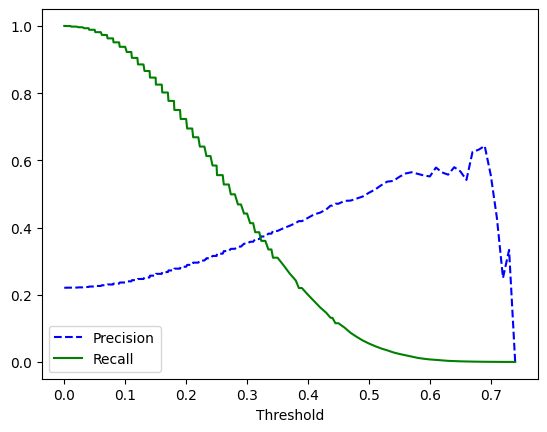

In [122]:
# Calculate precision and recall to generate the precision_recall_curve
from sklearn.metrics import precision_recall_curve
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train, proba_scores_forest)

# Plot the precision and recall curves
import matplotlib.pyplot as plt

plt.plot(thresholds_forest, precisions_forest[:-1], "b--", label="Precision")
plt.plot(thresholds_forest, recalls_forest[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")

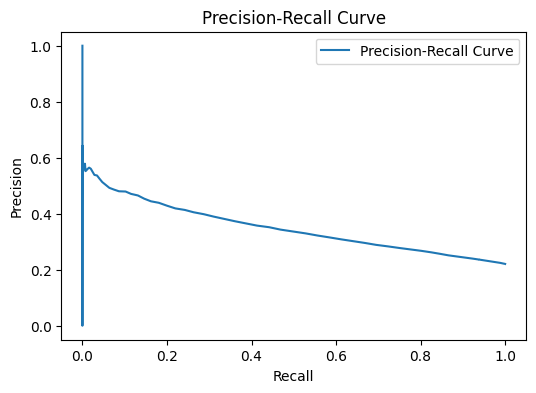

In [123]:
# Plot precisions against recalls
plt.figure(figsize=(6, 4))
plt.plot(recalls_forest, precisions_forest, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()

In [124]:
# Calculate the accumulated roc score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train, proba_scores_forest)

np.float64(0.6528782275972386)

# Compare

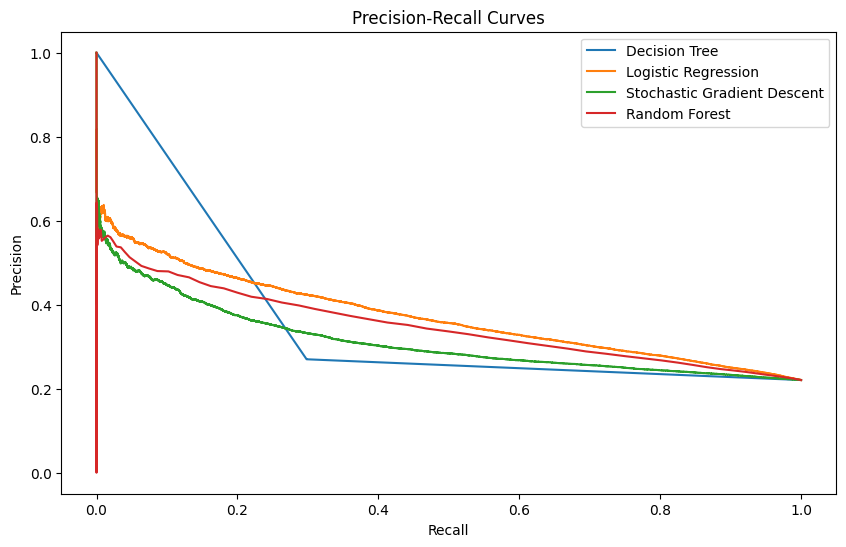

In [125]:
# Calculate the three different precisions, recalls, and tresholds
precisions_tree, recalls_tree, thresholds_tree = precision_recall_curve(y_train, proba_scores_tree)
precisions_log, recalls_log, thresholds_log = precision_recall_curve(y_train, proba_scores_log)
precisions_sgd, recalls_sgd, thresholds_sgd = precision_recall_curve(y_train, decision_scores_sgd)
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train, proba_scores_forest)

# Plot the precision against recall curves
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(recalls_tree, precisions_tree, label="Decision Tree")
plt.plot(recalls_log, precisions_log, label="Logistic Regression")
plt.plot(recalls_sgd, precisions_sgd, label="Stochastic Gradient Descent")
plt.plot(recalls_forest, precisions_forest, label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.show()

In [126]:
# prompt: Make a table with the three classifiers and their accuracy, precision and recall, and arc score

import pandas as pd

data = {
    'Classifier': ['Decision Tree', 'Logistic Regression', 'Stochastic Gradient Descent','Random Forest'],
    'Accuracy': [scores_tree.mean(), log_scores.mean(), scores_sgd.mean(), scores_forest.mean()],
    'Precision': [precision_tree, precision_log, precision_sgd, precision_forest],
    'Recall': [recall_tree, recall_log, recall_sgd, recall_forest],
    'ROC AUC Score': [roc_auc_score(y_train, proba_scores_tree), roc_auc_score(y_train, proba_scores_log), roc_auc_score(y_train, decision_scores_sgd), roc_auc_score(y_train, proba_scores_forest)]
}

df_results = pd.DataFrame(data)
df_results


,Classifier,Accuracy,Precision,Recall,ROC AUC Score
0,Decision Tree,0.667466,0.270274,0.298147,0.535046
1,Logistic Regression,0.781541,0.533877,0.079425,0.672765
2,Stochastic Gradient Descent,0.779564,0.630435,0.002707,0.601078
3,Random Forest,0.779842,0.512990,0.046992,0.652878


# Hyper-parameters Logistic Regression




In [48]:
# A logistic regression analysis using X_train and cv=3
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Assuming X_train and y_train are defined as in the provided code

log_reg = LogisticRegression(random_state=42,max_iter=1000)
log_scores= cross_val_score(log_reg, X_train, y_train, cv=3, scoring="accuracy")

print("Cross-validation scores:", log_scores)
print("Mean accuracy:", log_scores.mean())

Cross-validation scores: [0.78163618 0.78052397 0.78221646]
Mean accuracy: 0.7814588710707596


In [49]:
# prompt: Use grid search to find optimal hyper parameters for logistic regression

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization type
    'solver': ['liblinear', 'saga'] # Solvers that support l1 and l2
}

# Create a Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000) # Increased max_iter

# Create a GridSearchCV object
grid_search = GridSearchCV(log_reg, param_grid, cv=3, scoring='accuracy', return_train_score=True)

# Fit the grid search to your training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Get the best model from the grid search
best_log_reg = grid_search.best_estimator_

# Evaluate the best model on the test set
test_accuracy = best_log_reg.score(X_test, y_test)
print("Test accuracy:", test_accuracy)


Best hyperparameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.7818399106101707
Test accuracy: 0.7835722524303839


In [64]:
best_log_reg

LogisticRegression(C=0.1, max_iter=1000, penalty='l1', random_state=42,
                   solver='liblinear')

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


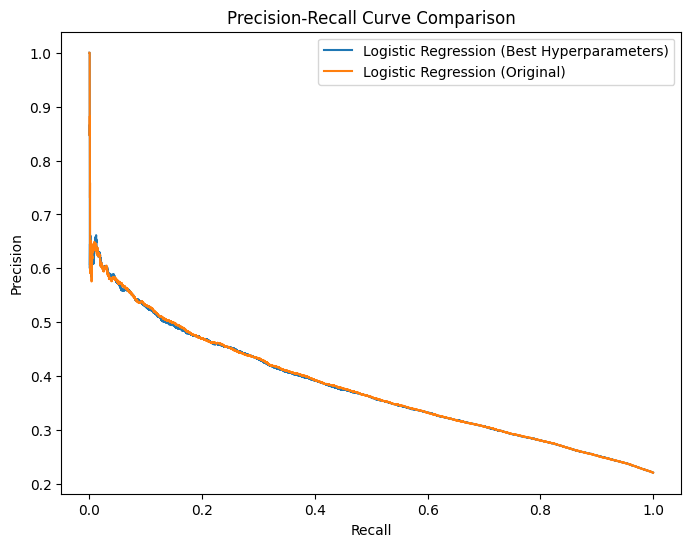

In [54]:
# prompt: generate the precision recall curve with best_params_. Do not use the sets set. Compare the result with the original default settings for logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Assuming X_train, y_train, and X_test, y_test are defined from previous code

# ... (Your existing code for data preparation and model training) ...


# Get the best model from the grid search
best_log_reg = grid_search.best_estimator_

# Predict probabilities for the training set using the best model
proba_scores_best_log = best_log_reg.predict_proba(X_train)[:, 1]


# Calculate precision and recall for the best model
precisions_best, recalls_best, thresholds_best = precision_recall_curve(y_train, proba_scores_best_log)

# Predict probabilities for the training set using the original model
log_reg_original = LogisticRegression(random_state=42) # original settings
log_reg_original.fit(X_train, y_train)
proba_scores_original = log_reg_original.predict_proba(X_train)[:, 1]

#Calculate precision and recall for the original model
precisions_original, recalls_original, thresholds_original = precision_recall_curve(y_train, proba_scores_original)


# Plot the precision-recall curves
plt.figure(figsize=(8, 6))
plt.plot(recalls_best, precisions_best, label="Logistic Regression (Best Hyperparameters)")
plt.plot(recalls_original, precisions_original, label="Logistic Regression (Original)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.show()


In [52]:
# prompt: Calculate the confusion matrix with best_params_

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

# Assuming best_log_reg and X_test, y_test are defined from previous code

# Predict the labels for the test set using the best model
y_train_pred = best_log_reg.predict(X_train)

# Calculate the confusion matrix
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx


array([[74276,  1398],
       [19735,  1694]])

# Hyper-parameter Random Forest

In [55]:
from sklearn.ensemble import RandomForestClassifier

# Assuming X_train and y_train are defined as in the provided code

forest_clf = RandomForestClassifier(random_state=42)
scores_forest = cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

print("Cross-validation scores:", scores_forest)
print("Mean accuracy:", scores_forest.mean())

Cross-validation scores: [0.77984429 0.77885566 0.78082615]
Mean accuracy: 0.7798420335532016


In [56]:
# prompt: Use grid-search to find optimal parameters for the Random Forest Classifier

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid to search
#param_grid = {
#    'n_estimators': [50, 100, 200],  # Number of trees in the forest
#    'max_depth': [None, 10, 20],  # Maximum depth of the trees
#    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
#    'min_samples_leaf': [1, 2, 4]  # Minimum samples required to be at a leaf node
#}

#Too many. I try with less.
param_grid = {
    'n_estimators': [75, 150],  # Number of trees in the forest
    'max_depth': [None, 10],  # Maximum depth of the trees
    'min_samples_split': [3, 7],  # Minimum samples required to split an internal node
    'min_samples_leaf': [1, 3]  # Minimum samples required to be at a leaf node
}

# Create a Random Forest Classifier
forest_clf = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(forest_clf, param_grid, cv=3, scoring='accuracy', return_train_score=True)

# Fit the grid search to your training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Get the best model from the grid search
best_forest_clf = grid_search.best_estimator_

# Evaluate the best model on the test set
test_accuracy = best_forest_clf.score(X_test, y_test)
print("Test accuracy:", test_accuracy)


Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 150}
Best score: 0.7813867783214326
Test accuracy: 0.782254078101829


In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid to search
#param_grid = {
#    'n_estimators': [50, 100, 200],  # Number of trees in the forest
#    'max_depth': [None, 10, 20],  # Maximum depth of the trees
#    'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
#    'min_samples_leaf': [1, 2, 4]  # Minimum samples required to be at a leaf node
#}

#Too many. I try with less.
param_grid = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [None],  # Maximum depth of the trees
    'min_samples_split': [5, 10],  # Minimum samples required to split an internal node
    'min_samples_leaf': [2, 4]  # Minimum samples required to be at a leaf node
}

# Create a Random Forest Classifier
forest_clf = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(forest_clf, param_grid, cv=3, scoring='accuracy', return_train_score=True)

# Fit the grid search to your training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Get the best model from the grid search
best_forest_clf = grid_search.best_estimator_

# Evaluate the best model on the test set
test_accuracy = best_forest_clf.score(X_test, y_test)
print("Test accuracy:", test_accuracy)


Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best score: 0.7816030537058755
Test accuracy: 0.7825424287362004


In [65]:
best_forest_clf

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [59]:
# prompt: calculate the confusion matrix with best_params_ for the random forest classifier

# Assuming best_forest_clf and X_train, y_train are defined from previous code

# Predict the labels for the training set using the best model
y_train_pred = best_forest_clf.predict(X_train)

# Calculate the confusion matrix
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx


array([[75674,     0],
       [ 9699, 11730]])

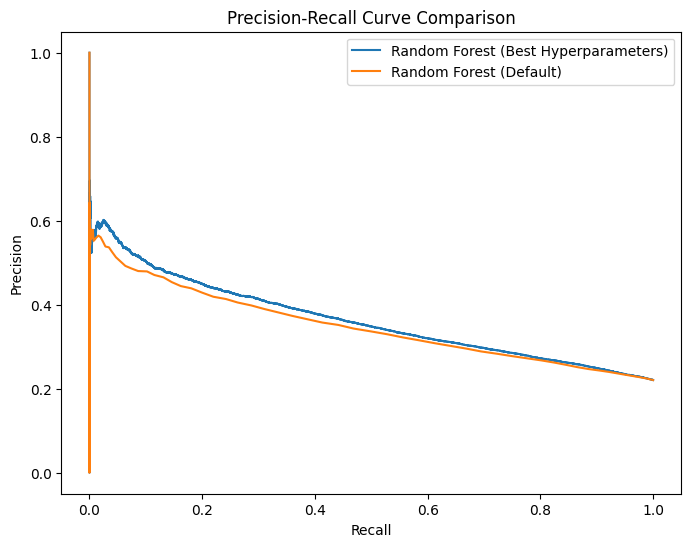

In [62]:
# prompt: generate the precision recall curve with best_params_ for the random forest classifier. Do not use the sets set. Use the result of the grid search that is already made. Compare with a model fit with default settings for random forest classifier, and proba_scores calculated with cross-val_predict and cv=3

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict

# Assuming grid_search is your GridSearchCV object for RandomForestClassifier
# and X_train, y_train are defined.


# Get the best model from the grid search
best_forest_clf = grid_search.best_estimator_

# Predict probabilities using the best model
proba_scores_best_forest = cross_val_predict(best_forest_clf, X_train, y_train, cv=3, method="predict_proba")[:, 1]

# Calculate precision and recall for the best model
precisions_best, recalls_best, thresholds_best = precision_recall_curve(y_train, proba_scores_best_forest)


# Train a Random Forest Classifier with default settings
forest_clf_default = RandomForestClassifier(random_state=42)
proba_scores_default = cross_val_predict(forest_clf_default, X_train, y_train, cv=3, method="predict_proba")[:,1]

# Calculate precision and recall for default model
precisions_default, recalls_default, thresholds_default = precision_recall_curve(y_train, proba_scores_default)


# Plot the precision-recall curves
plt.figure(figsize=(8, 6))
plt.plot(recalls_best, precisions_best, label="Random Forest (Best Hyperparameters)")
plt.plot(recalls_default, precisions_default, label="Random Forest (Default)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.legend()
plt.show()


In [63]:
grid_search.best_params_

{'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 200}

# Random Forest feature importance

In [77]:

# Get the best model from the grid search
best_forest_clf = grid_search.best_estimator_
for score, name in zip(best_forest_clf.feature_importances_, X_train.columns):
#    print(name, score)


SyntaxError: incomplete input (<ipython-input-77-8cc0814d36bc>, line 4)

In [67]:
# prompt: instead of printing the list. Sort it on descending feature importance value and then print it

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
# ... (Your existing code) ...

# Assuming grid_search is your GridSearchCV object for RandomForestClassifier
# and X_train, y_train are defined.

# Get the best model from the grid search
best_forest_clf = grid_search.best_estimator_

feature_importances = pd.DataFrame({'Feature': X_train.columns,
                                    'Importance': best_forest_clf.feature_importances_})

# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)


feature_importances


,Feature,Importance
143,cat_incomg1___INCOMG1,0.032267
131,lin_genhlth__GENHLTH,0.031867
141,lin_cd_ac_cd__SDHSTRE1,0.022221
139,lin_cd_ac_cd__SDHISOLT,0.019994
132,lin_emtsuprt__EMTSUPRT,0.017996
...,...,...
96,ter_1_2__MENTECIG,0.000545
135,lin_cd_ac_cd__CDHELP,0.000447
10,bin_1__HPVADVC4,0.000423
11,bin_1__CSRVTRT3,0.000293


In [73]:
feature_importances.head(15)

,Feature,Importance
143,cat_incomg1___INCOMG1,0.032267
131,lin_genhlth__GENHLTH,0.031867
141,lin_cd_ac_cd__SDHSTRE1,0.022221
139,lin_cd_ac_cd__SDHISOLT,0.019994
132,lin_emtsuprt__EMTSUPRT,0.017996
142,cat_covidnu1__COVIDNU1,0.017887
54,ter_1_2__PNEUVAC4,0.017198
61,ter_1_2__COVIDVA1,0.015732
130,lin_lsatisfy__LSATISFY,0.015323
121,ter_1_2__RENTHOM1,0.014661


In [74]:
feature_importances.tail(15)

,Feature,Importance
63,ter_1_2__COPDFLEM,0.001037
105,ter_1_2__LOADULK2,0.001023
66,ter_1_2__CSRVSUM,0.000981
67,ter_1_2__CSRVRTRN,0.000927
70,ter_1_2__CSRVDEIN,0.000852
69,ter_1_2__CSRVINSR,0.000823
95,ter_1_2__MENTCIGS,0.000783
71,ter_1_2__CSRVCLIN,0.000769
68,ter_1_2__CSRVINST,0.000743
152,cat_employ1__EMPLOY1_9.0,0.000612


# Predict on test

In [76]:
# prompt: Evaluate the Random forest Classifier with best estimator on the test set

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


# Evaluate the best Random Forest model on the test set
test_accuracy = best_forest_clf.score(X_test, y_test)
print(f"Test accuracy for best Random Forest Classifier: {test_accuracy}")

y_test_pred = best_forest_clf.predict(X_test)
conf_mx_test = confusion_matrix(y_test, y_test_pred)
print(f"Confusion matrix for test data:\n{conf_mx_test}")

precision_test = precision_score(y_test, y_test_pred)
print(f"Precision for test data: {precision_test}")

recall_test = recall_score(y_test, y_test_pred)
print(f"Recall for test data: {recall_test}")

f1_test = f1_score(y_test,y_test_pred)
print(f"F1 Score for test data: {f1_test}")

proba_scores_test = best_forest_clf.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, proba_scores_test)
print(f"ROC AUC score for test data: {roc_auc_test}")


Test accuracy for best Random Forest Classifier: 0.7825424287362004
Confusion matrix for test data:
[[18763   159]
 [ 5120   234]]
Precision for test data: 0.5954198473282443
Recall for test data: 0.04370564064251027
F1 Score for test data: 0.08143379154341396
ROC AUC score for test data: 0.6638033861519937
